In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import datetime
import ast
import statistics
import sys
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
from scipy.stats import mannwhitneyu
from scipy.stats import skew

In [13]:
# Checking the resolution of the examples

def excel_serial_to_datetime(serial):
    return datetime.datetime(1899, 12, 30) + datetime.timedelta(days=serial)

csv_file_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Data\CAHR Data\CAHR Combined - Physiology Data"
#save_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 1\All Data\All clean with CPP"

for file in os.listdir(csv_file_directory):
    
    df_individual= pd.read_csv(os.path.join(csv_file_directory, file))

    # converting the datetime to a format that python understands
    df_individual['datetime'] = df_individual['DateTime'].apply(excel_serial_to_datetime)
    df_individual.set_index('datetime', inplace=True)
    df_individual.drop(columns=['DateTime'], inplace=True)

    #df_individual_cleaned = df_individual.dropna()
    
    break

In [14]:
df_individual.head()

MAP    ICP    CPP    AMP     PRx     PAx  \
datetime                                                                 
2011-01-20 08:45:53.389987    NaN    NaN    NaN    NaN     NaN     NaN   
2011-01-20 08:46:53.389992  69.96  13.48  56.48  1.230     NaN     NaN   
2011-01-20 08:47:53.389988  69.01  13.83  55.18  1.297     NaN     NaN   
2011-01-20 08:48:53.389993  68.49  13.60  54.89  1.223  0.0787 -0.0385   
2011-01-20 08:49:53.389989  69.12  13.49  55.64  1.252  0.1505  0.0282   

                               RAC     RAP  CPPopt_PRx  LLA_PRx  ULA_PRx  \
datetime                                                                   
2011-01-20 08:45:53.389987     NaN     NaN         NaN      NaN      NaN   
2011-01-20 08:46:53.389992     NaN     NaN         NaN      NaN      NaN   
2011-01-20 08:47:53.389988     NaN     NaN         NaN      NaN      NaN   
2011-01-20 08:48:53.389993 -0.1759  0.5335         NaN      NaN      NaN   
2011-01-20 08:49:53.389989 -0.1176  0.5667         NaN      NaN      NaN   

                            CPPopt_PAx  LLA_PAx  ULA_PAx  CPPopt_RAC  LLA_RAC  \
datetime                                                                        
2011-01-20 08:45:53.389987         NaN      NaN      NaN         NaN      NaN   
2011-01-20 08:46:53.389992         NaN      NaN      NaN         NaN      NaN   
2011-01-20 08:47:53.389988         NaN      NaN      NaN         NaN      NaN   
2011-01-20 08:48:53.389993         NaN      NaN      NaN         NaN      NaN   
2011-01-20 08:49:53.389989         NaN      NaN      NaN         NaN      NaN   

                            ULA_RAC  
datetime                             
2011-01-20 08:45:53.389987      NaN  
2011-01-20 08:46:53.389992      NaN  
2011-01-20 08:47:53.389988      NaN  
2011-01-20 08:48:53.389993      NaN  
2011-01-20 08:49:53.389989      NaN

# Optimal ARIMA Model for Individual Patient 

In [206]:
warnings.filterwarnings('ignore')

csv_file_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Data\CAHR Data\CAHR Combined - Physiology Data"
files = os.listdir(csv_file_directory)
# The list of the parameters that need to be considered
parameter_list = ['RAP', 'ICP', 'AMP', 'MAP', 'CPP', 'RSO2_L', 'RSO2_R', 'PbtO2', 'PRx', \
                      'PAx', 'RAC', 'COx_L', 'COx_R', 'COxA_L', 'COxA_R']

parameter_list_modified = parameter_list + ['Patient']
# Defining the empty dataframe to save the optimal orders
df_resolution = pd.DataFrame(index=range(len(files)), columns=parameter_list_modified)
d = 0
count = 0
# Iterate through each patient
for index, file in enumerate(files):
    file = "CAHR-126.csv"
    df_individual = pd.read_csv(os.path.join(csv_file_directory, file))
    
    df_individual = df_individual.reindex(columns = parameter_list)
    df_individual_cleaned = df_individual.dropna(axis=1, how='all')
    #df_individual_cleaned = df_individual_cleaned.dropna()
    # Iterate through each parameter
    for parameter in parameter_list:
        # Checking if the parameter is in the dataframe columns
        if parameter in df_individual_cleaned.columns:
            
            aic_old = float('inf')
            optimal_ARIMA = {'p': None, 'd': None, 'q': None}

            first_ord_diff = df_individual_cleaned[parameter].dropna()
            # Checking for the optimal order: p and q range 1 to 10 
            for p in range(1, 2):
                for q in range(1, 2):

                    try:
                        model = ARIMA(first_ord_diff, order=(p, d, q))
                        model_fit = model.fit()
                        aic_new = model_fit.aic

                        if aic_new < aic_old:
                            aic_old = aic_new
                            optimal_ARIMA['p'], optimal_ARIMA['d'], optimal_ARIMA['q'] = p, 1, q

                    except Exception as e:
                        print(f"An error occurred: {str(e)}")

            print("Combination done till p =", p, "and q =", q)
            print("Best combination for", parameter, "is", optimal_ARIMA, "Best AIC value:", aic_old)
            print("--------------------------------------------------")

            formatted_aic_old = "{:.3f}".format(aic_old)
            df_resolution.at[index, parameter] = [optimal_ARIMA['p'], 1, optimal_ARIMA['q'], formatted_aic_old]

    df_resolution.at[index, 'Patient'] = file[:-4]
    print(df_resolution.iloc[index])
    count+=1

#         print("--------------------------------------------------")
#         print("--------------------------------------------------\n")
        
#         tac = timer()

#         print("Execution time: ",round(tac-tic, 3), "seconds")
    
    if count > 2:
        break

An error occurred: zero-size array to reduction operation maximum which has no identity
Combination done till p = 1 and q = 1
Best combination for RAP is {'p': None, 'd': None, 'q': None} Best AIC value: inf
--------------------------------------------------
An error occurred: zero-size array to reduction operation maximum which has no identity
Combination done till p = 1 and q = 1
Best combination for ICP is {'p': None, 'd': None, 'q': None} Best AIC value: inf
--------------------------------------------------
An error occurred: zero-size array to reduction operation maximum which has no identity
Combination done till p = 1 and q = 1
Best combination for AMP is {'p': None, 'd': None, 'q': None} Best AIC value: inf
--------------------------------------------------
An error occurred: zero-size array to reduction operation maximum which has no identity
Combination done till p = 1 and q = 1
Best combination for MAP is {'p': None, 'd': None, 'q': None} Best AIC value: inf
---------------

In [229]:
for index, file in enumerate(files):
    file = "CAHR-95.csv"
    df_individual = pd.read_csv(os.path.join(csv_file_directory, file))
    
    df_individual = df_individual.reindex(columns = parameter_list)
    df_individual_cleaned = df_individual.dropna(axis=1, how='all')
    for parameter in parameter_list:
        if parameter in df_individual_cleaned.columns:
            first_ord_diff = df_individual_cleaned[parameter].dropna()
            first_ord_diff = first_ord_diff.diff().dropna()
            print(first_ord_diff.shape[0])
        
        
    #df_individual_cleaned = df_individual_cleaned.dropna()
    break

7000
7016
7016
7016
6848
7185
7187
1051
6813
6812
6812
6810
6813
6986
6989


In [230]:
df_individual_cleaned

RAP     ICP    AMP    MAP    CPP  RSO2_L  RSO2_R  PbtO2     PRx  \
0        NaN     NaN    NaN    NaN    NaN     NaN     NaN    NaN     NaN   
1        NaN -1.0090  1.154  68.34  69.35   72.28   58.99  11.74     NaN   
2        NaN -1.1090  1.140  67.97  69.08   72.42   58.84  11.83     NaN   
3     0.7225 -0.9797  1.153  67.72  68.70   72.12   58.99  11.83  0.0835   
4     0.7942 -1.0570  1.141  67.95  69.01   72.11   58.99  11.83  0.2850   
...      ...     ...    ...    ...    ...     ...     ...    ...     ...   
7188  0.8240     NaN    NaN  93.80    NaN   72.58   64.53    NaN -0.4968   
7189     NaN     NaN    NaN  87.72    NaN   72.99   63.68    NaN     NaN   
7190     NaN     NaN    NaN  86.21    NaN   72.99   63.79    NaN     NaN   
7191     NaN     NaN    NaN  85.93    NaN   72.99   63.21    NaN     NaN   
7192     NaN     NaN    NaN  85.44    NaN     NaN     NaN    NaN     NaN   

         PAx     RAC   COx_L   COx_R  COxA_L  COxA_R  
0        NaN     NaN     NaN     NaN     NaN     NaN  
1        NaN     NaN     NaN     NaN     NaN     NaN  
2        NaN     NaN     NaN     NaN     NaN     NaN  
3     0.1012 -0.0470  0.7006  0.2123  0.6028  0.2698  
4     0.2735  0.0969  0.5962  0.1947  0.4730  0.2347  
...      ...     ...     ...     ...     ...     ...  
7188 -0.7368 -0.8477 -0.4296 -0.2366 -0.1721  0.0551  
7189     NaN     NaN     NaN     NaN -0.1863  0.2850  
7190     NaN     NaN     NaN     NaN -0.1820  0.4481  
7191     NaN     NaN     NaN     NaN -0.5926  0.3857  
7192     NaN     NaN     NaN     NaN -0.4869  0.4746  

[7193 rows x 15 columns]

## RAP trichotomize based on thresholds

## Scatterplots (piece-wise linear regression)

In [195]:
# Splitting the files according to measurement methods

tic = timer()

csv_file_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Data\CAHR Data\CAHR Combined - Physiology Data"
files = os.listdir(csv_file_directory)

parameter_list_ICP_ABP_measures = ['RAP', 'ICP', 'AMP', 'MAP', 'CPP', 'PRx', 'PAx', 'RAC']
parameter_list_NIRS_measures = ['RAP', 'ICP', 'AMP', 'MAP', 'CPP', 'RSO2_L', 'RSO2_R', 'PRx', 'PAx', \
                      'RAC', 'COx_L', 'COx_R', 'COxA_L', 'COxA_R']
parameter_list_PbtO2_measures = ['RAP', 'ICP', 'AMP', 'MAP', 'CPP', 'PRx', 'PAx', 'RAC', 'PbtO2']
                      
files_ICP_ABP_measures = []
files_NIRS_measures = []
files_PbtO2_measures = []

for file in files:
    df_individual = pd.read_csv(os.path.join(csv_file_directory, file))
    df_individual = df_individual.dropna(axis=1, how='all')
    if all(col in df_individual.columns for col in parameter_list_ICP_ABP_measures):
        files_ICP_ABP_measures.append(file)
    if all(col in df_individual.columns for col in parameter_list_NIRS_measures):
        files_NIRS_measures.append(file)
    if all(col in df_individual.columns for col in parameter_list_PbtO2_measures):
        files_PbtO2_measures.append(file)
        
tac = timer()
print("Execution time: ",round(tac-tic, 3), "seconds")

Execution time:  14.283 seconds


In [196]:
print(len(files_ICP_ABP_measures))
print(len(files_NIRS_measures))
print(len(files_PbtO2_measures))

379
133
116


In [145]:
# Reading all the files and concatenating

csv_file_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Data\CAHR Data\CAHR Combined - Physiology Data"
files = os.listdir(csv_file_directory)

df_all = pd.DataFrame()

parameter_list = ['RAP', 'ICP', 'AMP', 'MAP', 'CPP', 'PRx',  'PAx', 'RAC', 'RSO2_L', 'RSO2_R', \
                'COx_L', 'COx_R', 'COxA_L', 'COxA_R', 'PbtO2', ]

for file in files:
    df_individual= pd.read_csv(os.path.join(csv_file_directory, file))
    df_individual_cleaned = df_individual.reindex(columns = parameter_list)
    
    filter_condition = (df_individual_cleaned['ICP'] > 100) | (df_individual_cleaned['ICP'] < 0) | \
                       (df_individual_cleaned['MAP'] > 200) | (df_individual_cleaned['MAP'] < 0) | \
                       (df_individual_cleaned['AMP'] > 40)
    df_individual_cleaned = df_individual_cleaned[~filter_condition] 
    
    df_all = pd.concat([df_all, df_individual_cleaned], axis=0, ignore_index=True)

In [ ]:
# Reading all the files and concatenating
def concatenating_files(files):
    
    df_all = pd.DataFrame(index=range(len(files)), columns=parameter_list_modified)

    for file in files:
        df_individual= pd.read_csv(os.path.join(csv_file_directory, file))
        df_individual_cleaned = df_individual.reindex(columns = parameter_list)

        filter_condition = (df_individual_cleaned['ICP'] > 100) | (df_individual_cleaned['ICP'] < 0) | \
                           (df_individual_cleaned['MAP'] > 200) | (df_individual_cleaned['MAP'] < 0) | \
                           (df_individual_cleaned['AMP'] > 40) | 
        df_individual_cleaned = df_individual_cleaned[~filter_condition] 

        df_all = pd.concat([df_all, df_individual_cleaned], axis=0, ignore_index=True)

In [82]:
df_all.head()

RAP    ICP    AMP    MAP    CPP  RSO2_L  RSO2_R  PbtO2     PRx     PAx  \
0     NaN    NaN    NaN    NaN    NaN     NaN     NaN    NaN     NaN     NaN   
1     NaN  13.48  1.230  69.96  56.48     NaN     NaN    NaN     NaN     NaN   
2     NaN  13.83  1.297  69.01  55.18     NaN     NaN    NaN     NaN     NaN   
3  0.5335  13.60  1.223  68.49  54.89     NaN     NaN    NaN  0.0787 -0.0385   
4  0.5667  13.49  1.252  69.12  55.64     NaN     NaN    NaN  0.1505  0.0282   

      RAC  COx_L  COx_R  COxA_L  COxA_R  
0     NaN    NaN    NaN     NaN     NaN  
1     NaN    NaN    NaN     NaN     NaN  
2     NaN    NaN    NaN     NaN     NaN  
3 -0.1759    NaN    NaN     NaN     NaN  
4 -0.1176    NaN    NaN     NaN     NaN

In [141]:
def scatter_plot_with_piece_wise_linear_regression(segments, dependent_param):
    
    warnings.filterwarnings('ignore')
    
    NIRS_measures_list = ['RSO2_L', 'RSO2_R', 'COx_L', 'COx_R', 'COxA_L', 'COxA_R']
    
    segment1 = segments[0][['RAP', dependent_param]].dropna()
    segment2 = segments[1][['RAP', dependent_param]].dropna()
    segment3 = segments[2][['RAP', dependent_param]].dropna()
    
    if dependent_param in NIRS_measures_list:
        segment1 = segment1[(segment1 != 0).all(axis=1)]
        segment2 = segment2[(segment2 != 0).all(axis=1)]
        segment3 = segment3[(segment3 != 0).all(axis=1)]
    
    # Fitting linear regression models for each segment
    model1 = LinearRegression().fit(segment1[['RAP']], segment1[dependent_param])
    model2 = LinearRegression().fit(segment2[['RAP']], segment2[dependent_param])
    model3 = LinearRegression().fit(segment3[['RAP']], segment3[dependent_param])

    # Predict values for plotting
    x_range1 = np.linspace(segment1['RAP'].min(), segment1['RAP'].max(), 100).reshape(-1, 1)
    x_range2 = np.linspace(segment2['RAP'].min(), segment2['RAP'].max(), 100).reshape(-1, 1)
    x_range3 = np.linspace(segment3['RAP'].min(), segment3['RAP'].max(), 100).reshape(-1, 1)

    y_pred1 = model1.predict(x_range1)
    y_pred2 = model2.predict(x_range2)
    y_pred3 = model3.predict(x_range3)

    plt.figure(figsize=(10, 8))
    
    if dependent_param in NIRS_measures_list:
        df_pair = df_all[['RAP', dependent_param]]
        df_pair = df_pair[(df_pair != 0).all(axis=1)]
        plt.scatter(df_pair['RAP'], df_pair[dependent_param], alpha=0.6)
    else:
        # Scatterplot
        plt.scatter(df_all['RAP'], df_all[dependent_param], alpha=0.6)

    # Plot fitted lines
    plt.plot(x_range1, y_pred1, color='darkred', label='RAP < 0 Fit')
    plt.plot(x_range2, y_pred2, color='darkgreen', label='0 ≤ RAP ≤ 0.4 Fit')
    plt.plot(x_range3, y_pred3, color='#CCCC00', label='RAP > 0.4 Fit')

    # Add titles and labels
    title = 'Piece-wise Linear Regression with Two Thresholds Between RAP and ' + dependent_param
    plt.title(title)
    plt.xlabel('RAP')
    plt.ylabel(dependent_param)
    plt.legend(loc='upper left')
    
    save_image_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Plots\Piece_wise_linear_regression\RAP_independent"
    save_image_name = 'RAP and ' + dependent_param
    #plt.savefig(os.path.join(save_image_directory, save_image_name))
    
    plt.show()

    # Print slopes and intercepts
    print(f"RAP < 0 Fit: Slope = {model1.coef_[0]:.2f}, Intercept = {model1.intercept_:.2f}")
    print(f"0 ≤ RAP ≤ 0.4 Fit: Slope = {model2.coef_[0]:.2f}, Intercept = {model2.intercept_:.2f}")
    print(f"RAP > 0.4 Fit: Slope = {model3.coef_[0]:.2f}, Intercept = {model3.intercept_:.2f}")
    
    return round(model1.coef_[0], 2), round(model2.coef_[0], 2), round(model3.coef_[0], 2)

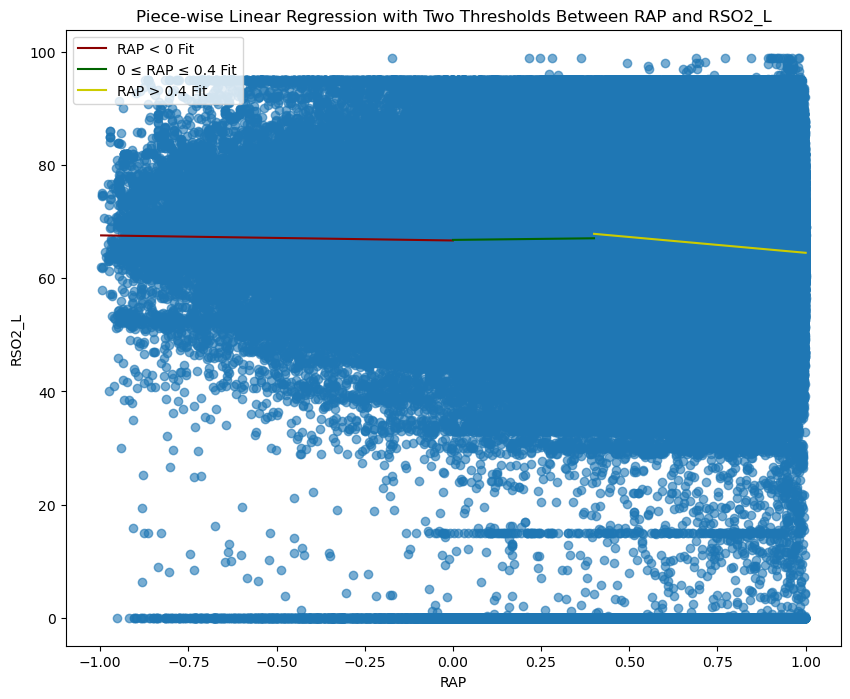

RAP < 0 Fit: Slope = -0.90, Intercept = 66.68
0 ≤ RAP ≤ 0.4 Fit: Slope = 0.72, Intercept = 66.78
RAP > 0.4 Fit: Slope = -5.59, Intercept = 70.09
Execution time: 5.11 seconds


In [112]:
# For a single dependent parameter
breakpoints = [0, 0.4]

segment1 = df_all[df_all['RAP'] < breakpoints[0]]
segment2 = df_all[(df_all['RAP'] >= breakpoints[0]) & (df_all['RAP'] <= breakpoints[1])]
segment3 = df_all[df_all['RAP'] > breakpoints[1]]

segments = [segment1, segment2, segment3]

dependent_param = 'RSO2_L'
scatter_plot_with_piece_wise_linear_regression(segments, dependent_param)

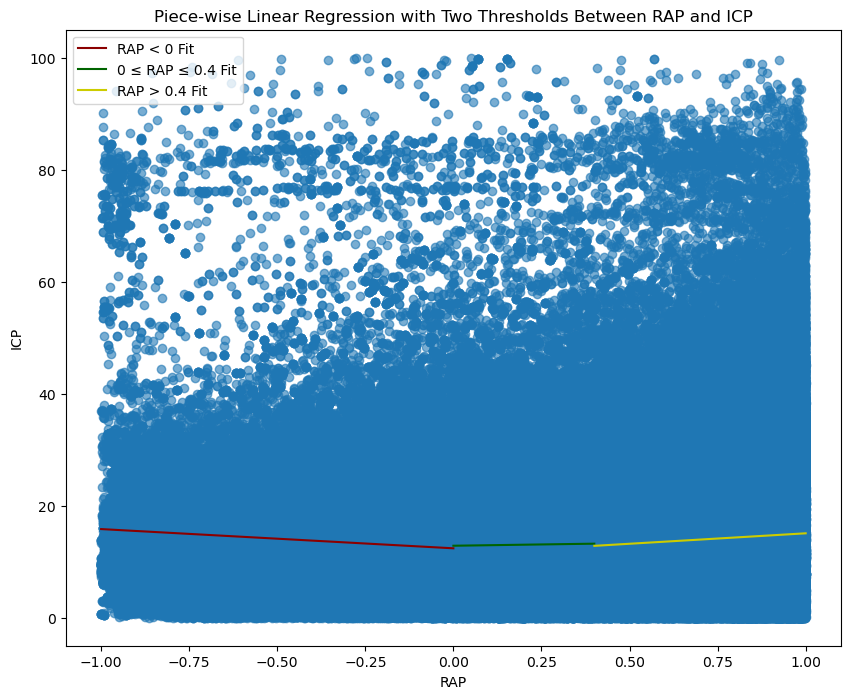

RAP < 0 Fit: Slope = -3.43, Intercept = 12.39
0 ≤ RAP ≤ 0.4 Fit: Slope = 0.92, Intercept = 12.85
RAP > 0.4 Fit: Slope = 3.73, Intercept = 11.34


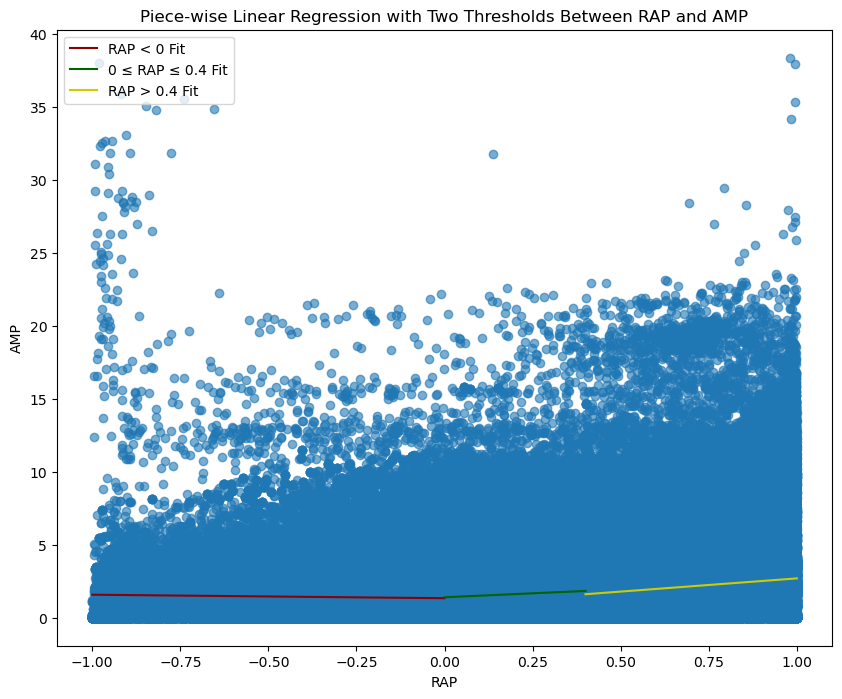

RAP < 0 Fit: Slope = -0.24, Intercept = 1.34
0 ≤ RAP ≤ 0.4 Fit: Slope = 1.09, Intercept = 1.40
RAP > 0.4 Fit: Slope = 1.81, Intercept = 0.89


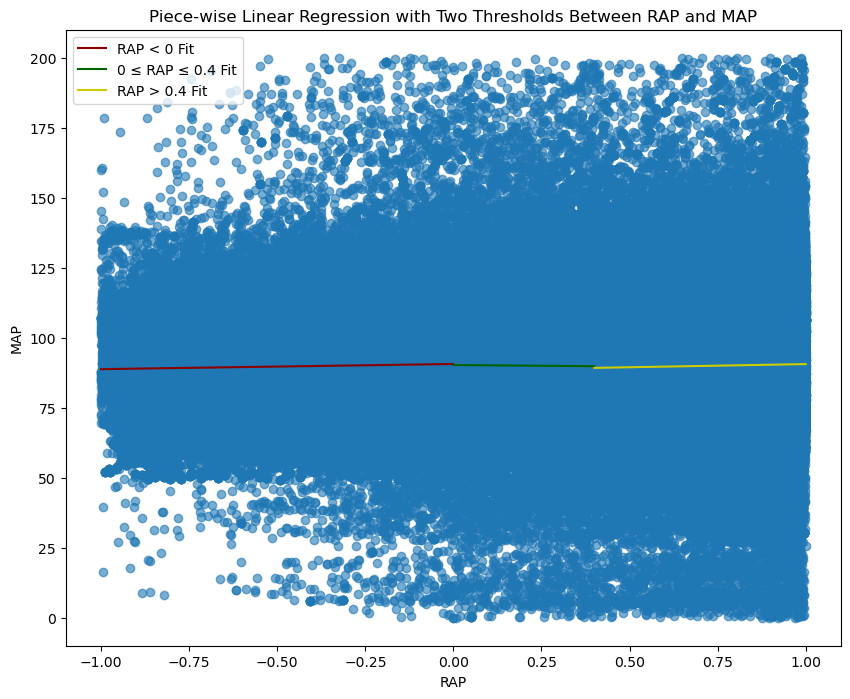

RAP < 0 Fit: Slope = 1.85, Intercept = 90.62
0 ≤ RAP ≤ 0.4 Fit: Slope = -1.05, Intercept = 90.25
RAP > 0.4 Fit: Slope = 2.25, Intercept = 88.34


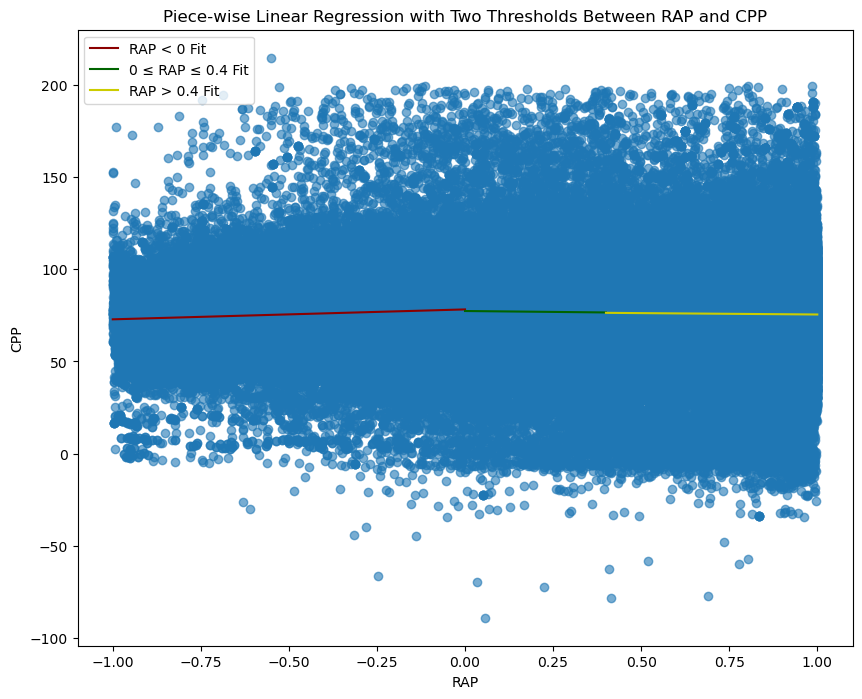

RAP < 0 Fit: Slope = 5.38, Intercept = 78.22
0 ≤ RAP ≤ 0.4 Fit: Slope = -1.95, Intercept = 77.36
RAP > 0.4 Fit: Slope = -1.50, Intercept = 76.97


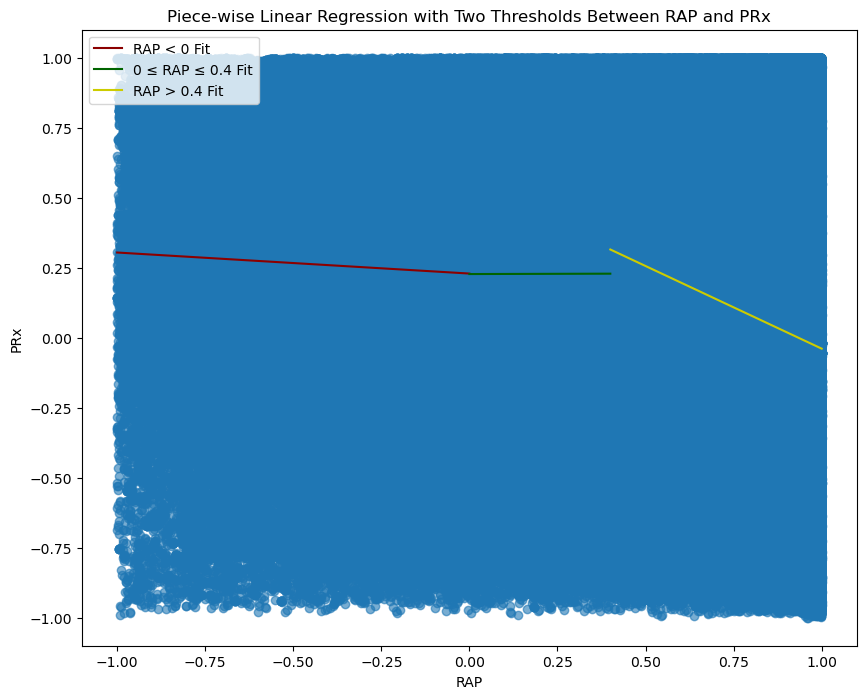

RAP < 0 Fit: Slope = -0.08, Intercept = 0.23
0 ≤ RAP ≤ 0.4 Fit: Slope = 0.00, Intercept = 0.23
RAP > 0.4 Fit: Slope = -0.59, Intercept = 0.55


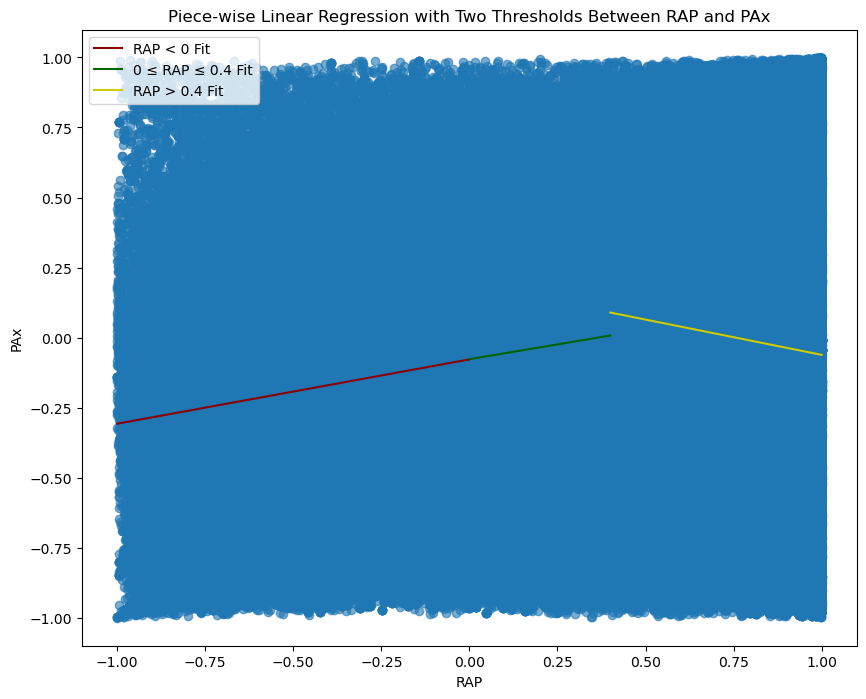

RAP < 0 Fit: Slope = 0.23, Intercept = -0.08
0 ≤ RAP ≤ 0.4 Fit: Slope = 0.21, Intercept = -0.08
RAP > 0.4 Fit: Slope = -0.25, Intercept = 0.19


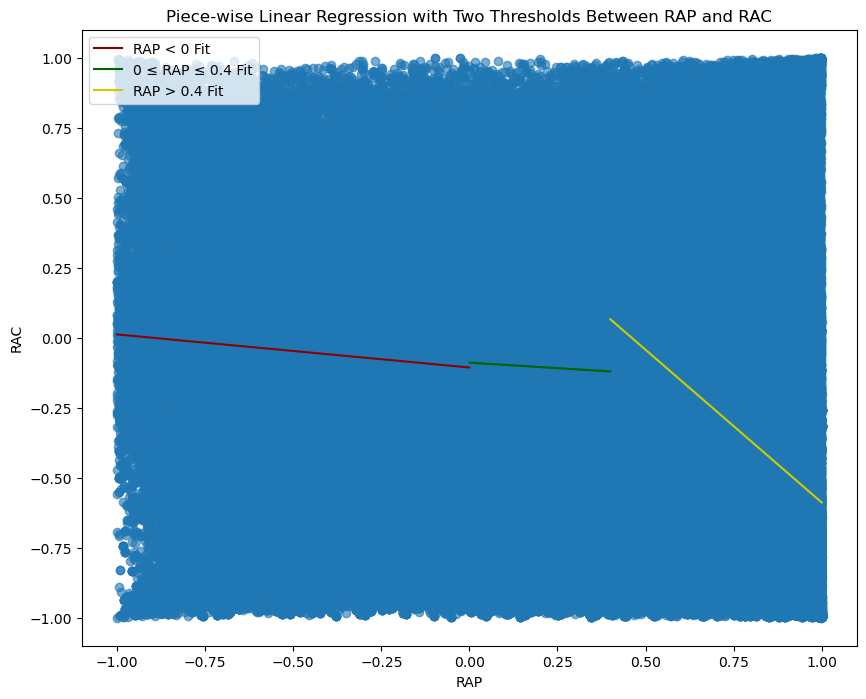

RAP < 0 Fit: Slope = -0.12, Intercept = -0.11
0 ≤ RAP ≤ 0.4 Fit: Slope = -0.08, Intercept = -0.09
RAP > 0.4 Fit: Slope = -1.09, Intercept = 0.50


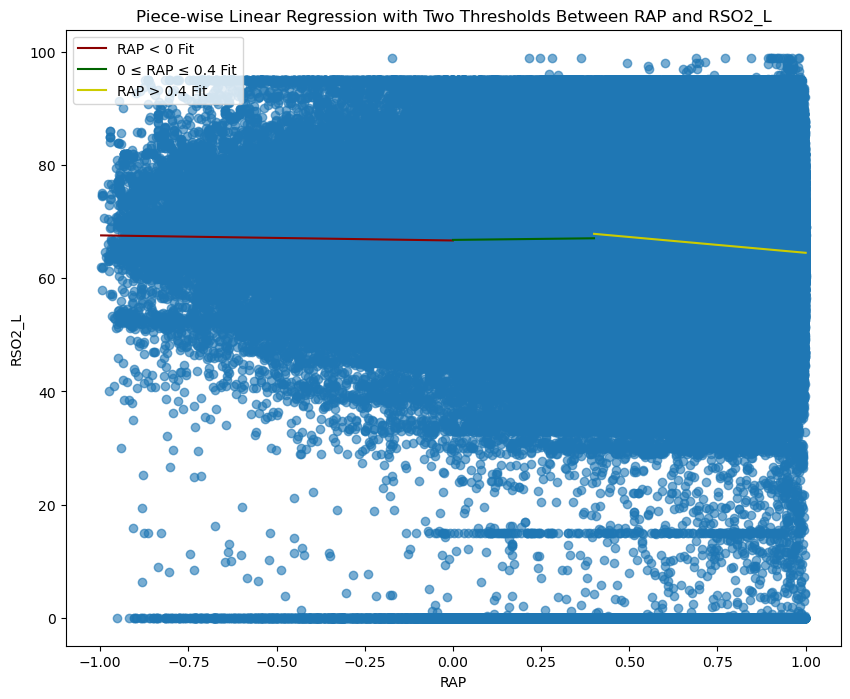

RAP < 0 Fit: Slope = -0.90, Intercept = 66.68
0 ≤ RAP ≤ 0.4 Fit: Slope = 0.72, Intercept = 66.78
RAP > 0.4 Fit: Slope = -5.59, Intercept = 70.09


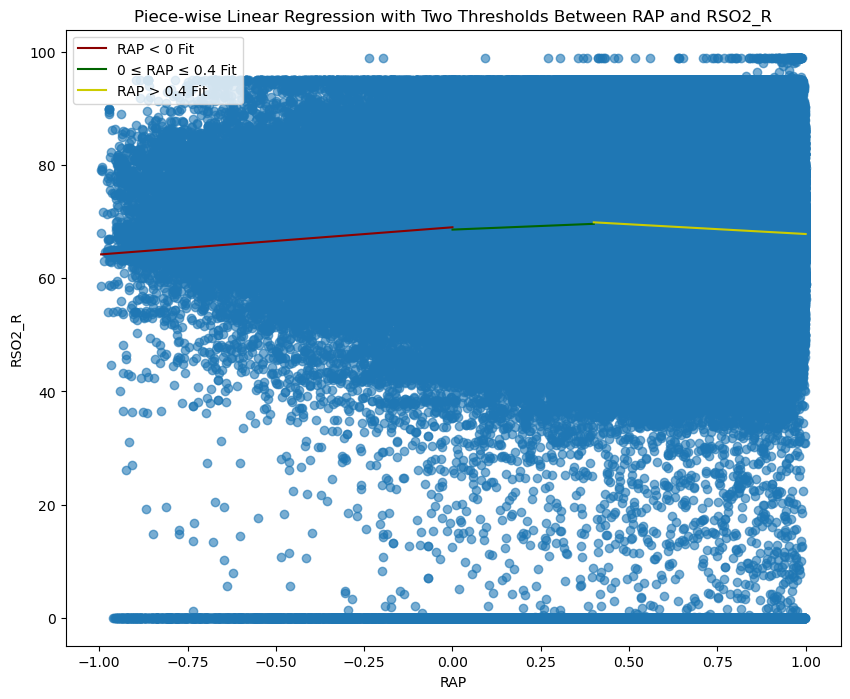

RAP < 0 Fit: Slope = 4.81, Intercept = 69.01
0 ≤ RAP ≤ 0.4 Fit: Slope = 2.55, Intercept = 68.60
RAP > 0.4 Fit: Slope = -3.44, Intercept = 71.27


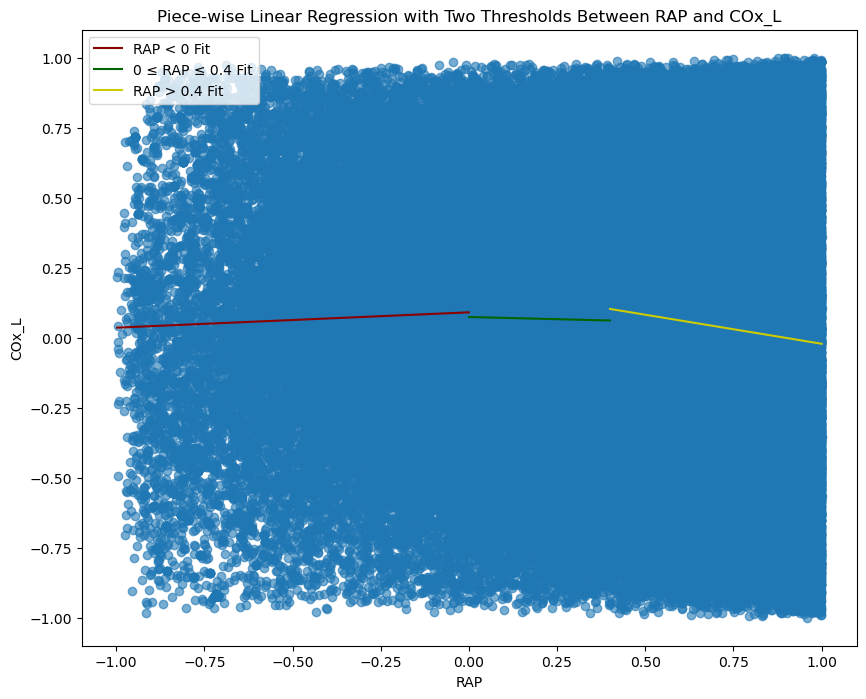

RAP < 0 Fit: Slope = 0.05, Intercept = 0.09
0 ≤ RAP ≤ 0.4 Fit: Slope = -0.03, Intercept = 0.07
RAP > 0.4 Fit: Slope = -0.21, Intercept = 0.19


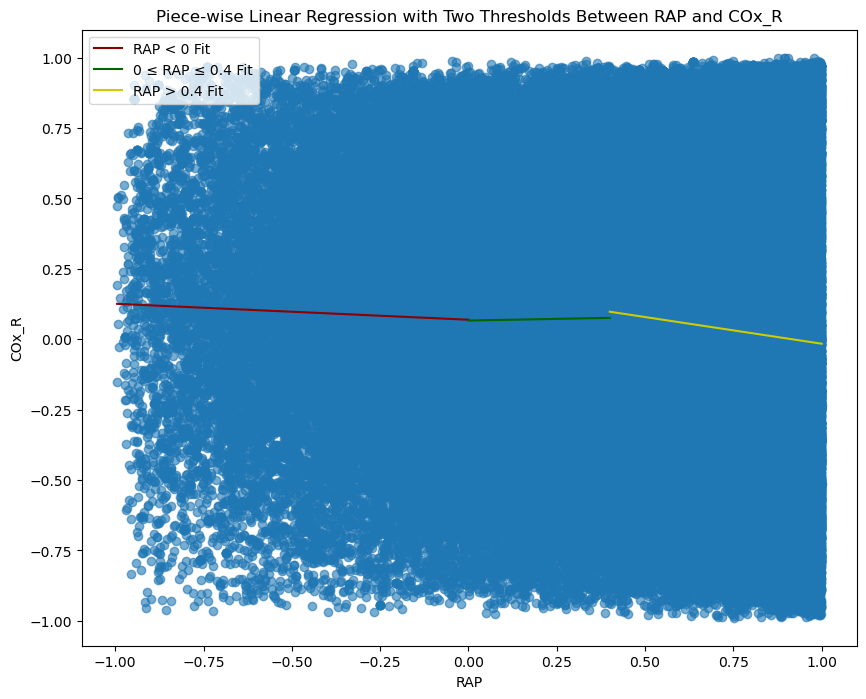

RAP < 0 Fit: Slope = -0.06, Intercept = 0.07
0 ≤ RAP ≤ 0.4 Fit: Slope = 0.02, Intercept = 0.07
RAP > 0.4 Fit: Slope = -0.19, Intercept = 0.17


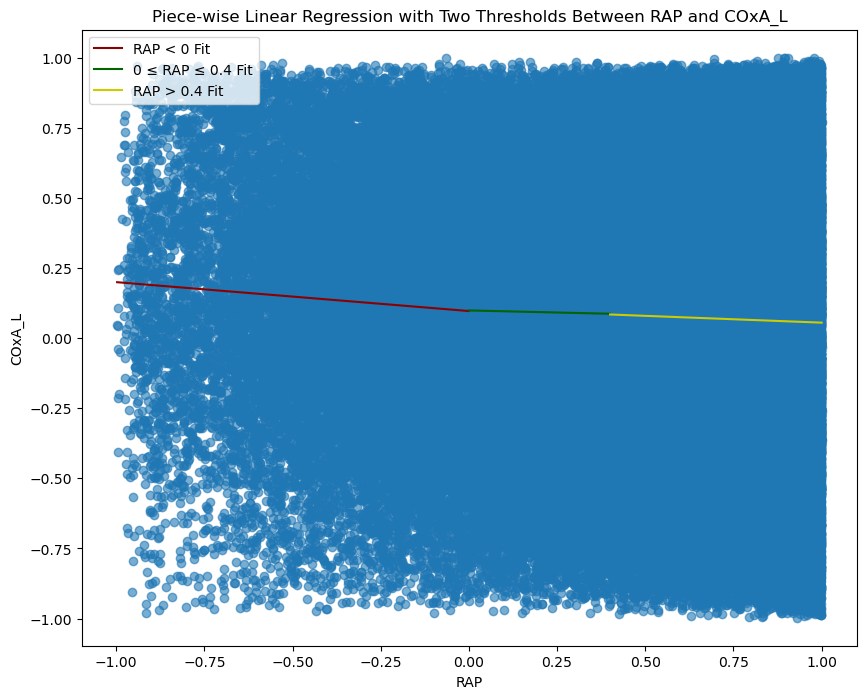

RAP < 0 Fit: Slope = -0.10, Intercept = 0.10
0 ≤ RAP ≤ 0.4 Fit: Slope = -0.03, Intercept = 0.10
RAP > 0.4 Fit: Slope = -0.05, Intercept = 0.10


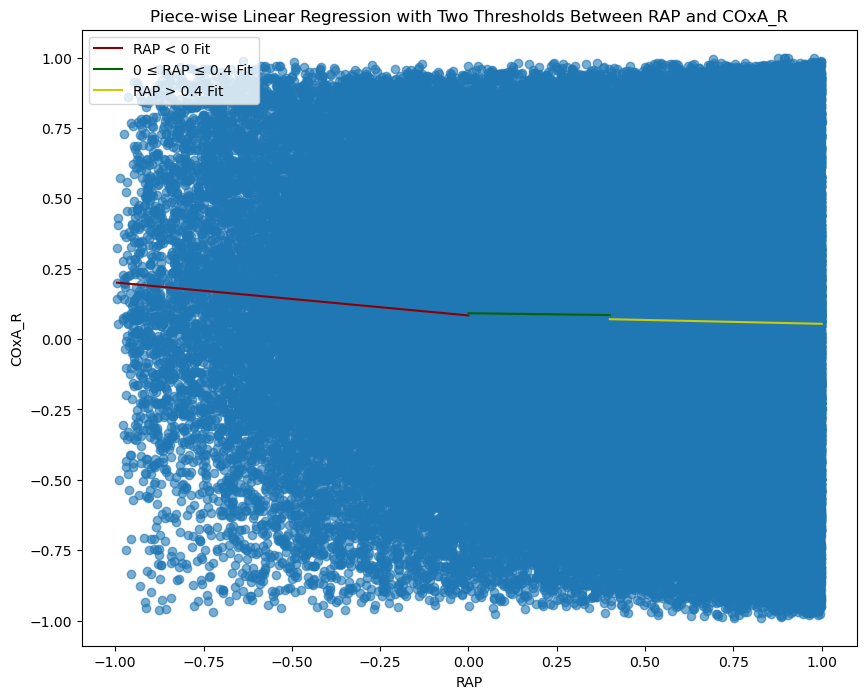

RAP < 0 Fit: Slope = -0.12, Intercept = 0.08
0 ≤ RAP ≤ 0.4 Fit: Slope = -0.02, Intercept = 0.09
RAP > 0.4 Fit: Slope = -0.03, Intercept = 0.08


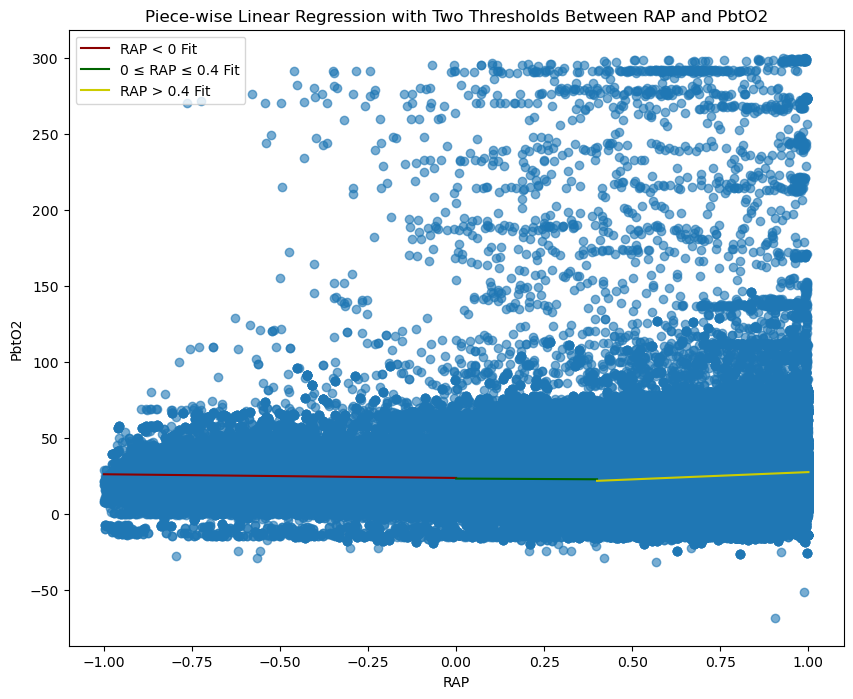

RAP < 0 Fit: Slope = -2.43, Intercept = 23.58
0 ≤ RAP ≤ 0.4 Fit: Slope = -1.22, Intercept = 23.18
RAP > 0.4 Fit: Slope = 9.58, Intercept = 17.84


In [147]:
breakpoints = [0, 0.4]

segment1 = df_all[df_all['RAP'] < breakpoints[0]]
segment2 = df_all[(df_all['RAP'] >= breakpoints[0]) & (df_all['RAP'] <= breakpoints[1])]
segment3 = df_all[df_all['RAP'] > breakpoints[1]]

segments = [segment1, segment2, segment3]

labels = ['RAP < 0', '0 ≤ RAP ≤ 0.4', 'RAP > 0.4']
columns = df_all.columns.to_list()
columns.remove('RAP')
columns.insert(0, 'Labels')
df_slope = pd.DataFrame(index=range(len(labels)), columns=columns)


for index, parameter in enumerate(df_all.columns):
    if index == 0:           # excluding RAP 
        pass
    else:
        slope_1, slope_2, slope_3 = scatter_plot_with_piece_wise_linear_regression(segments, parameter)
        df_slope.at[0, parameter] = slope_1
        df_slope.at[1, parameter] = slope_2
        df_slope.at[2, parameter] = slope_3
        
    df_slope['Labels'] = labels
    

In [151]:
df_slope

ICP   AMP   MAP   CPP   PRx   PAx   RAC RSO2_L RSO2_R COx_L  \
Labels                                                                        
RAP < 0       -3.43 -0.24  1.85  5.38 -0.08  0.23 -0.12   -0.9   4.81  0.05   
0 ≤ RAP ≤ 0.4  0.92  1.09 -1.05 -1.95   0.0  0.21 -0.08   0.72   2.55 -0.03   
RAP > 0.4      3.73  1.81  2.25  -1.5 -0.59 -0.25 -1.09  -5.59  -3.44 -0.21   

              COx_R COxA_L COxA_R PbtO2  
Labels                                   
RAP < 0       -0.06   -0.1  -0.12 -2.43  
0 ≤ RAP ≤ 0.4  0.02  -0.03  -0.02 -1.22  
RAP > 0.4     -0.19  -0.05  -0.03  9.58

## Boxplots

In [85]:
def boxplots_with_thresholds(segments, dependent_param):
    
    tic = timer()
    warnings.filterwarnings('ignore')
    
    segment1 = segments[0][['RAP', dependent_param]].dropna()
    segment2 = segments[1][['RAP', dependent_param]].dropna()
    segment3 = segments[2][['RAP', dependent_param]].dropna()
    
    plt.boxplot([segment1[dependent_param], segment2[dependent_param], segment3[dependent_param]], labels=['RAP < 0', '0 ≤ RAP ≤ 0.4', 'RAP > 0.4'])
    title = dependent_param + ' Measures at Different RAP Thresholds'
    plt.title(title)
    plt.tight_layout()

    save_image_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Plots\Boxplots\RAP_independent"
    save_image_name = 'RAP and ' + dependent_param
    plt.savefig(os.path.join(save_image_directory, save_image_name))

    plt.show()
    
    tac = timer()
    print("Execution time:", round(tac-tic, 2), "seconds")

In [139]:
def boxplots_with_values(values, dependent_param, df_all):
    
    tic = timer()
    warnings.filterwarnings('ignore')
    
    NIRS_measures_list = ['RSO2_L', 'RSO2_R', 'COx_L', 'COx_R', 'COxA_L', 'COxA_R']
    
    labels = []
    segments = []
    
    for index in range(len(values)-1):
        label = "[" + str(values[index]) + "," + str(values[index+1]) + ")"
        labels.append(label)
        segment = df_all[(df_all['RAP'] >= values[index]) & (df_all['RAP'] < values[index+1])]
        if dependent_param in NIRS_measures_list:
            segment = segment[(segment != 0).all(axis=1)]
        segments.append(segment[dependent_param].dropna())
        
    plt.figure(figsize=(8, 6))
    plt.boxplot(segments, labels=labels, showfliers=False)
    title = dependent_param + ' Measures at Different RAP Values'
    plt.title(title)
    plt.xticks(fontsize=8)
    plt.xlabel("RAP")
    plt.ylabel(dependent_param)
    plt.axvline(x=5.5, color='black', linestyle='--', linewidth=1)  # Approx middle of 0 and 0.2
    plt.axvline(x=7.5, color='black', linestyle='--', linewidth=1)  # Approx middle of 0.4 and 0.6

    plt.tight_layout()

    save_image_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Plots\Boxplots_v2\RAP_independent"
    save_image_name = 'RAP and ' + dependent_param
    #plt.savefig(os.path.join(save_image_directory, save_image_name))

    plt.show()
    
    tac = timer()
    print("Execution time:", round(tac-tic, 2), "seconds")

In [ ]:
# For all the parameters
breakpoints = [0, 0.4]

segment1 = df_all[df_all['RAP'] < breakpoints[0]]
segment2 = df_all[(df_all['RAP'] >= breakpoints[0]) & (df_all['RAP'] <= breakpoints[1])]
segment3 = df_all[df_all['RAP'] > breakpoints[1]]

segments = [segment1, segment2, segment3]

for index, parameter in enumerate(df_all.columns):
    if index == 0:           # excluding RAP 
        pass
    else:
        boxplots_with_thresholds(segments, parameter)

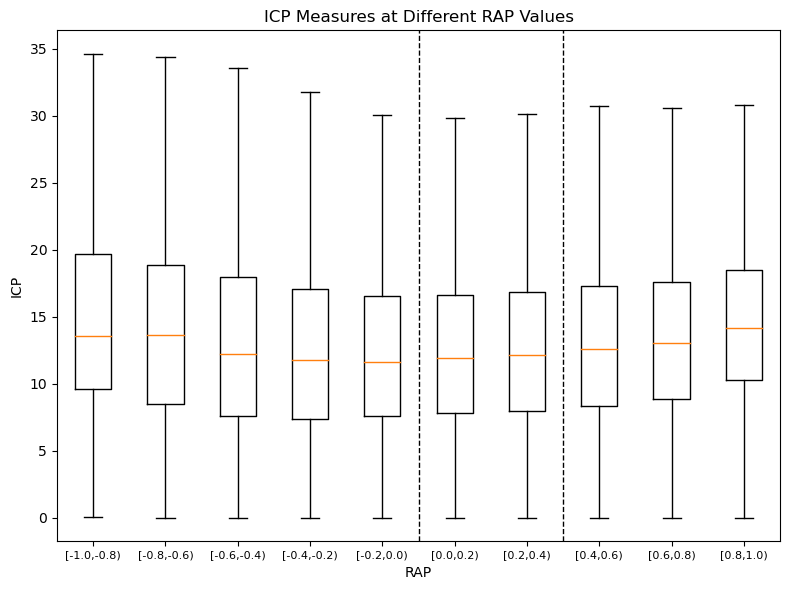

Execution time: 0.6 seconds


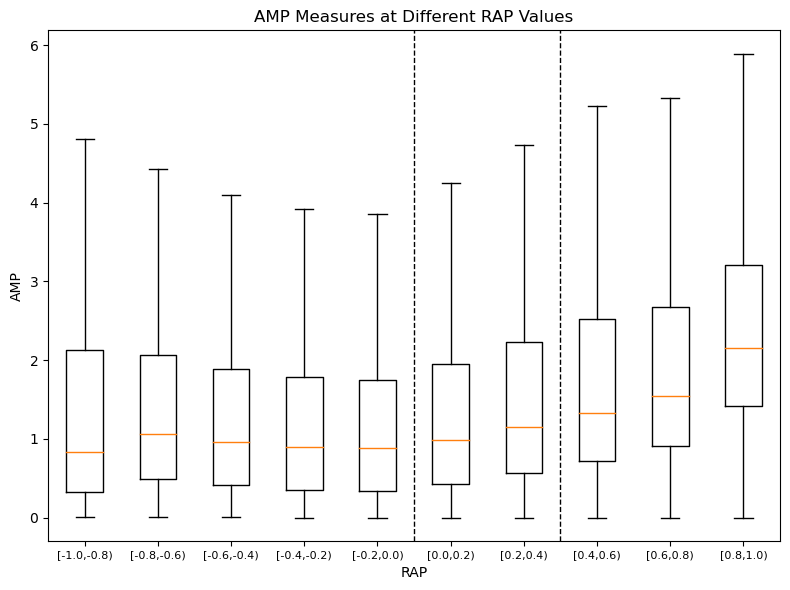

Execution time: 0.6 seconds


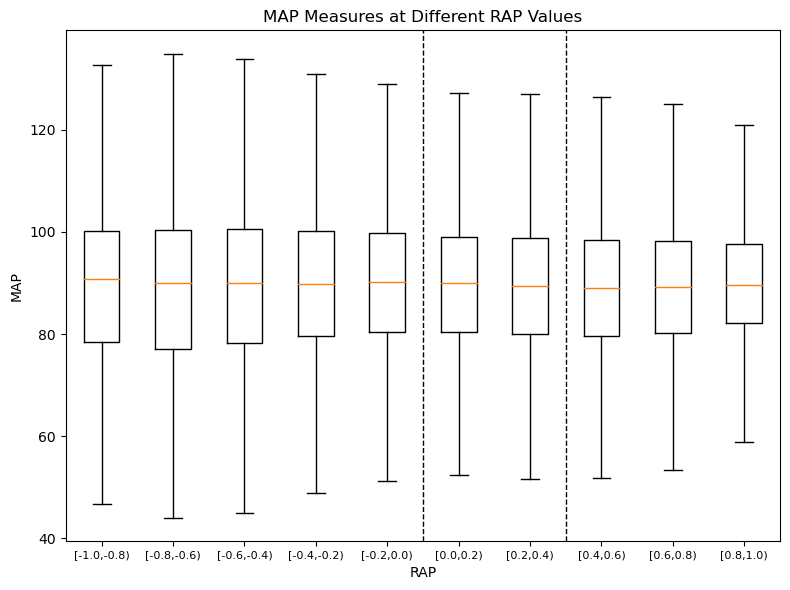

Execution time: 0.64 seconds


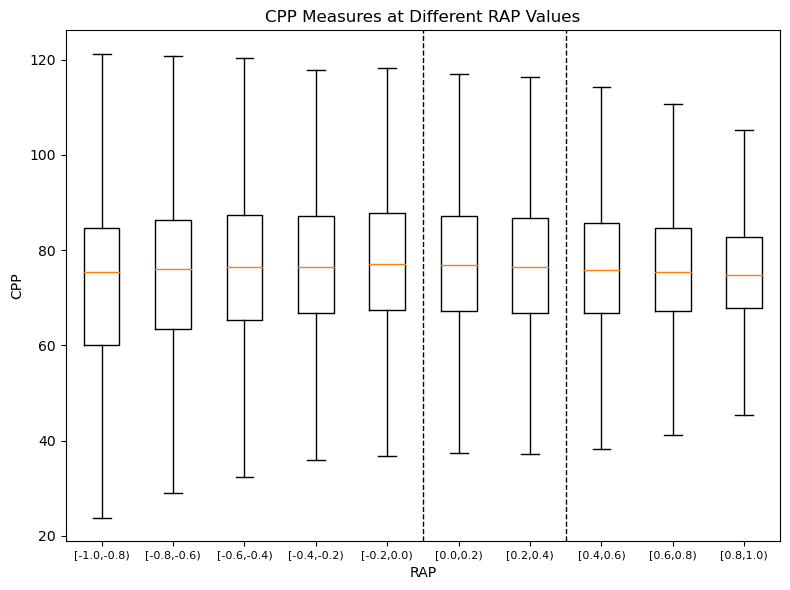

Execution time: 0.6 seconds


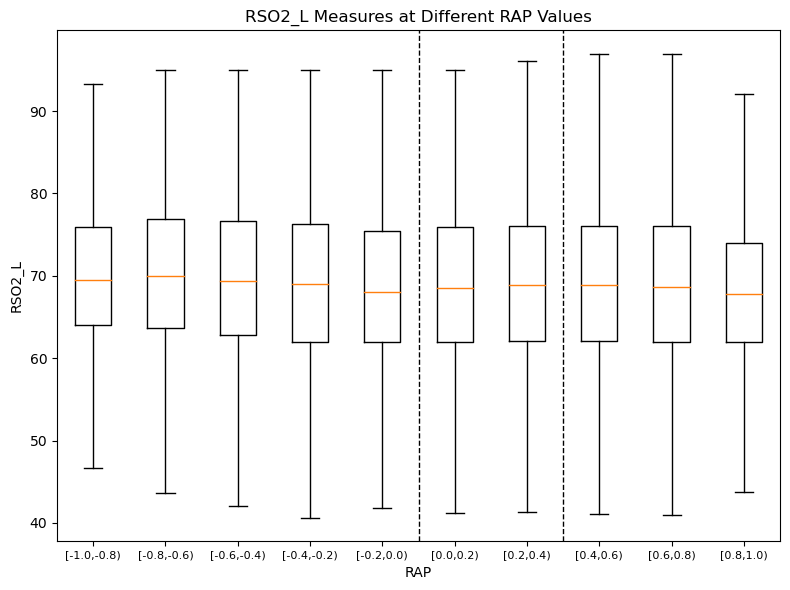

Execution time: 0.81 seconds


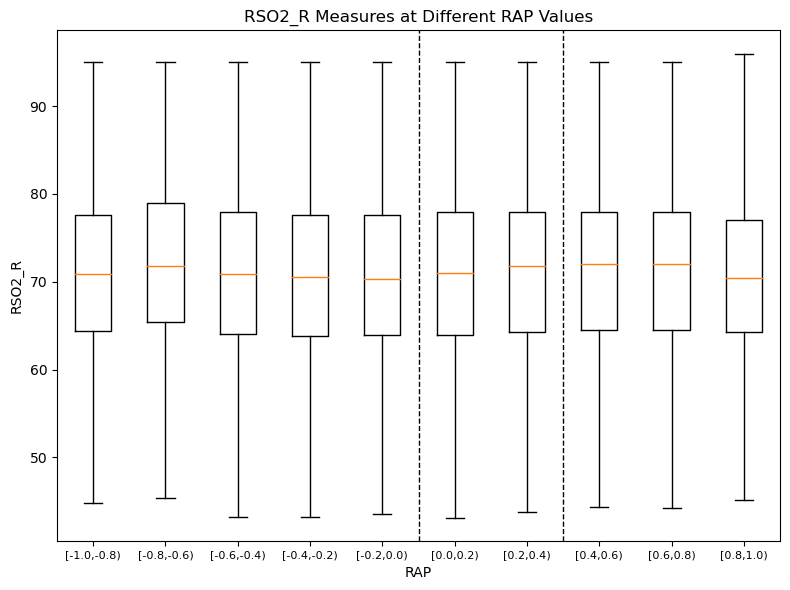

Execution time: 0.74 seconds


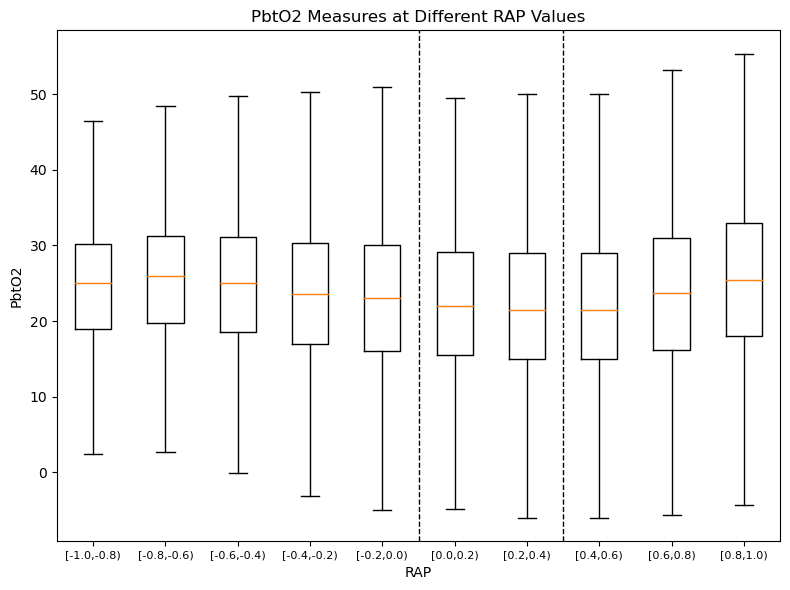

Execution time: 0.57 seconds


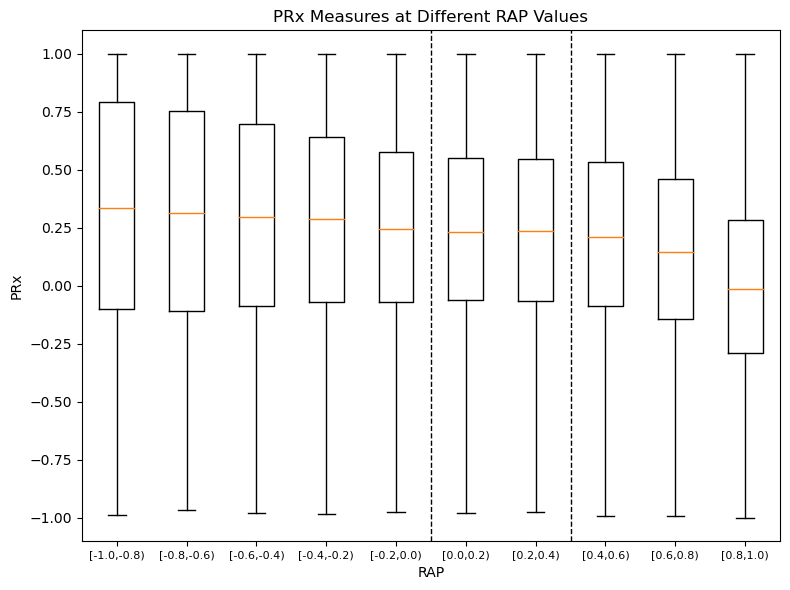

Execution time: 0.61 seconds


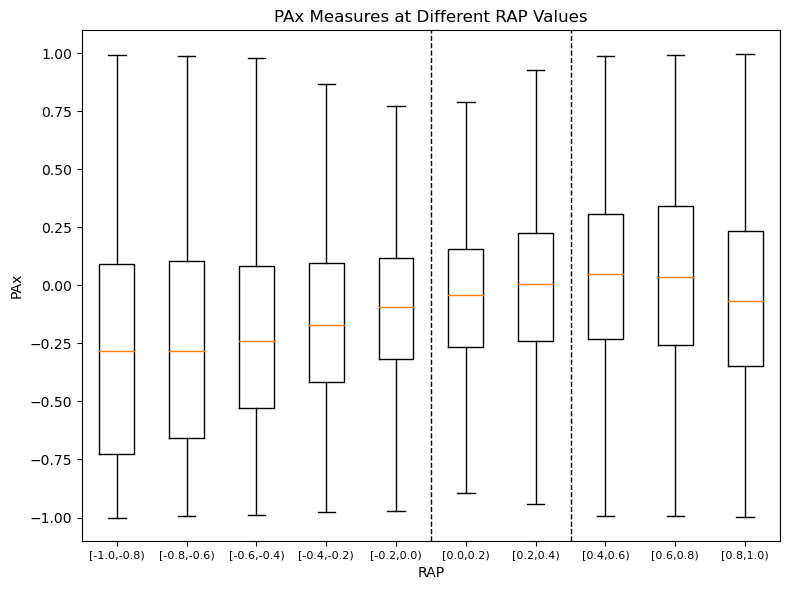

Execution time: 0.64 seconds


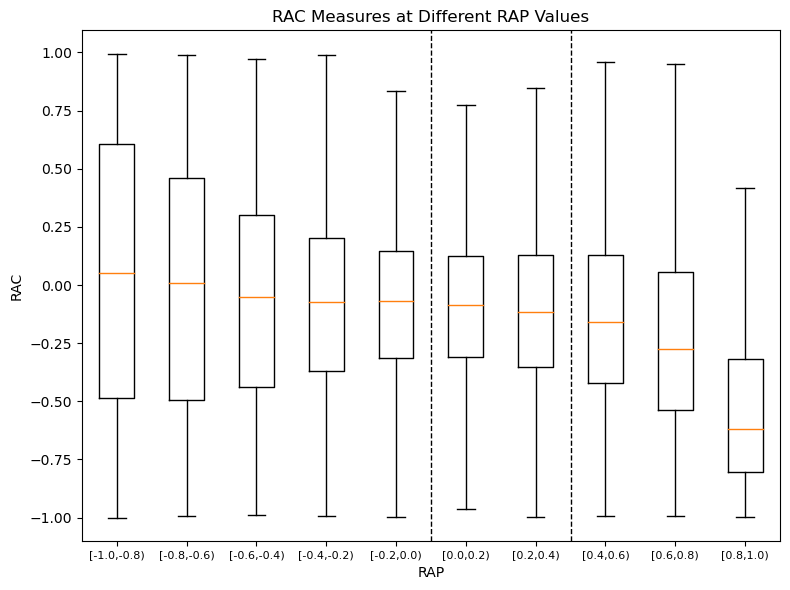

Execution time: 0.63 seconds


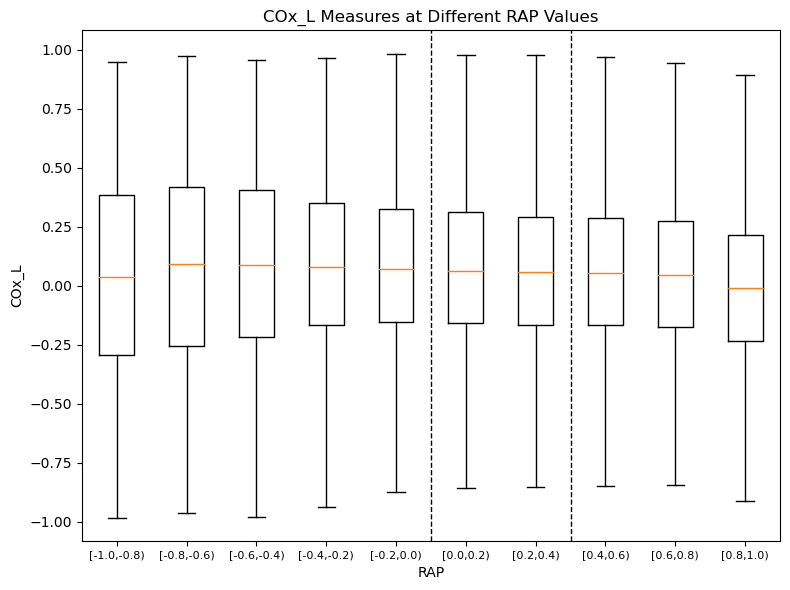

Execution time: 0.76 seconds


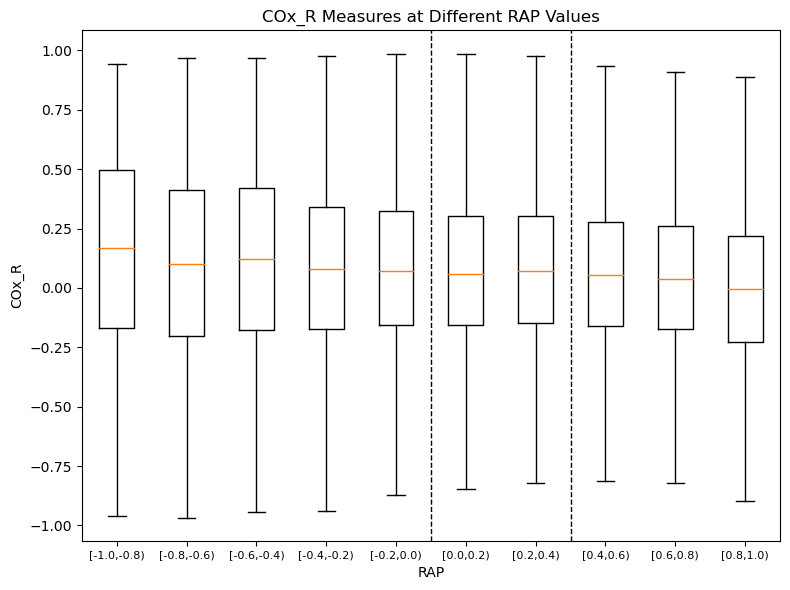

Execution time: 0.87 seconds


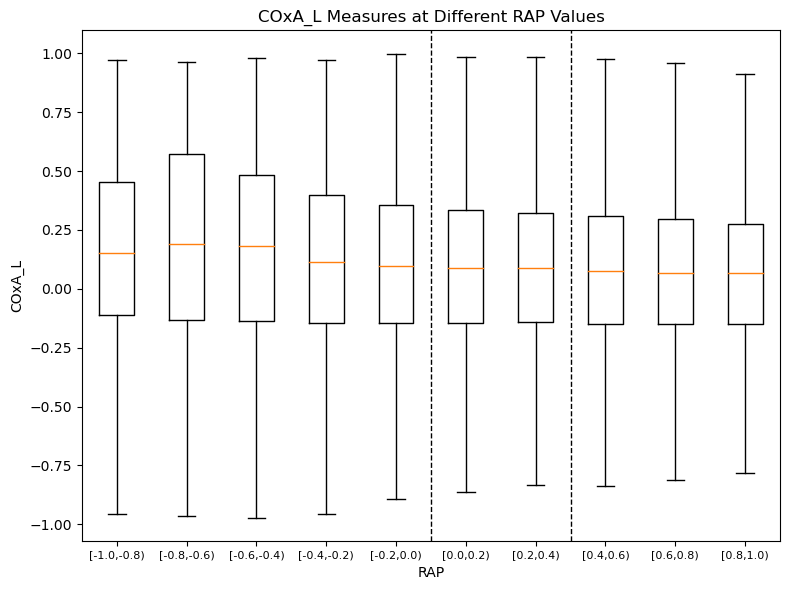

Execution time: 0.73 seconds


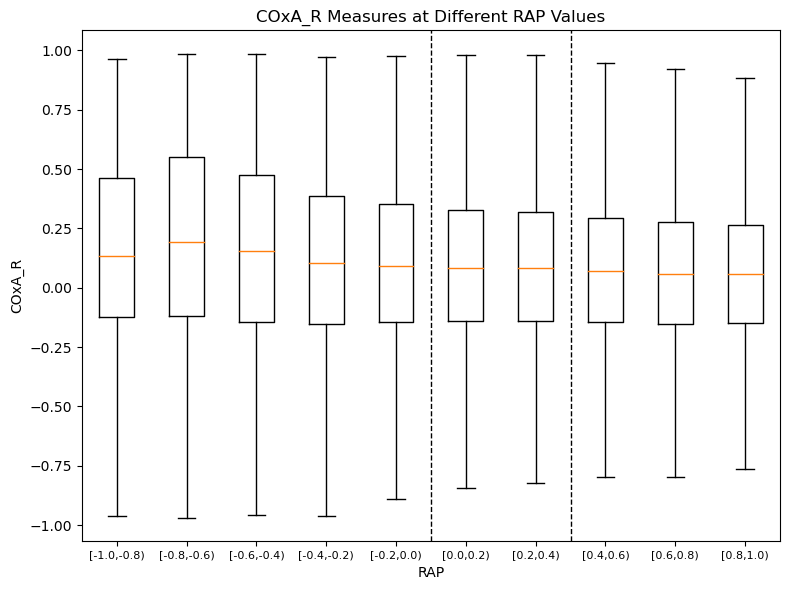

Execution time: 0.75 seconds


In [138]:
values = np.round(np.arange(-1, 1.1, 0.2), 1)
values = np.where(values == -0.0, 0.0, values)

for index, parameter in enumerate(df_all.columns):
    if index == 0:           # excluding RAP 
        pass
    else:
        boxplots_with_values(values, parameter, df_all)

In [131]:
values = np.round(np.arange(-1, 1.1, 0.2), 1)
values = np.where(values == -0.0, 0.0, values)
values

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

## Contour Plots

In [89]:
def contour_plot_across_full_spectrum(breakpoints, dependent_param):
    
    tic = timer()
    warnings.filterwarnings('ignore')
    
    segment = df_all[['RAP', 'ICP', dependent_param]].dropna()
    
    # Extract X, Y, and Z columns
    x = segment['RAP']
    y = segment['ICP']
    z = segment[dependent_param]
    
    # Create grid data for contour plot
    grid_x, grid_y = np.meshgrid(
        np.linspace(x.min(), x.max(), 100),
        np.linspace(y.min(), y.max(), 100)
    )

    # Interpolate Z values on the grid
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')

    # Plot the contour
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=20, cmap='viridis')
    plt.colorbar(contour, label=dependent_param)
    
    plt.axvline(x=breakpoints[0], color='black', linestyle='--', linewidth=2)  
    plt.axvline(x=breakpoints[1], color='black', linestyle='--', linewidth=2)
    
    title = 'Contour Plot of ' + dependent_param
    plt.title(title)
    plt.xlabel('RAP')
    plt.ylabel('ICP')

    save_image_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Plots\Contour_plots\RAP_independent"
    save_image_name = 'RAP and ' + dependent_param
    #plt.savefig(os.path.join(save_image_directory, save_image_name))

    plt.show()
    
    tac = timer()
    print("Execution time:", round(tac-tic, 2), "seconds")

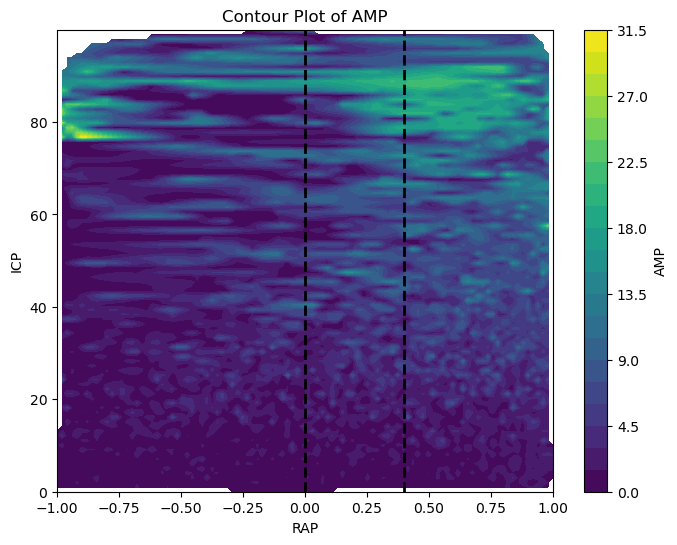

Execution time: 60.02 seconds


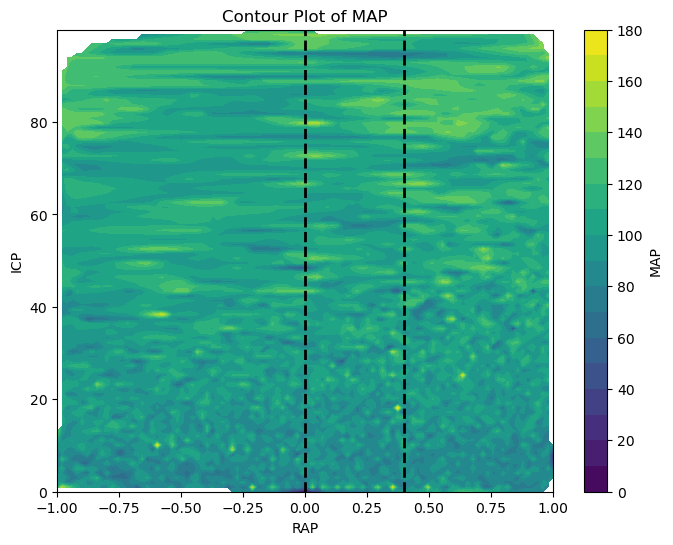

Execution time: 58.15 seconds


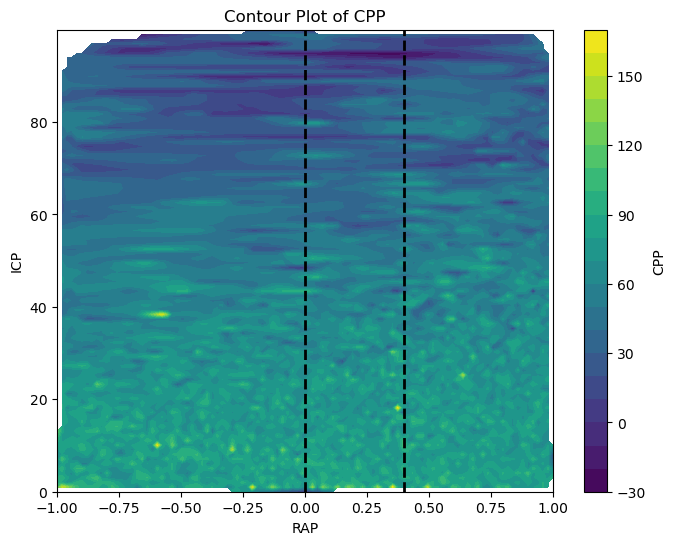

Execution time: 61.51 seconds


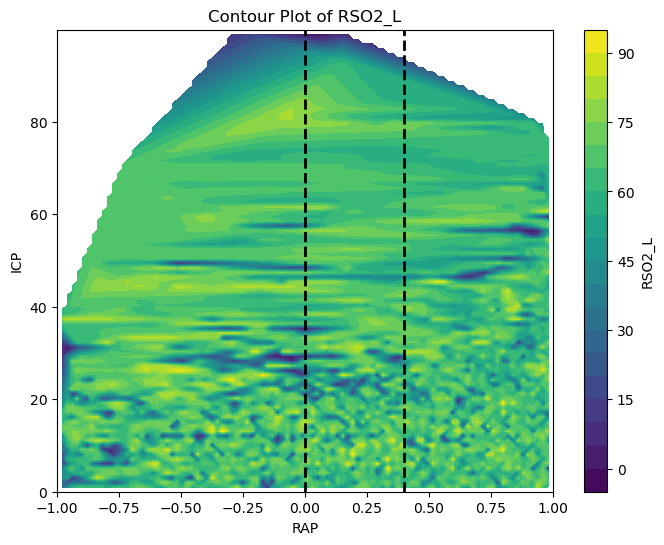

Execution time: 17.4 seconds


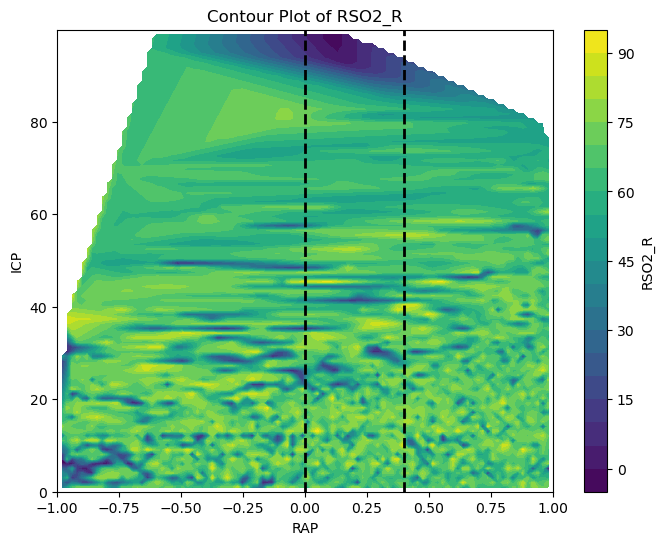

Execution time: 17.26 seconds


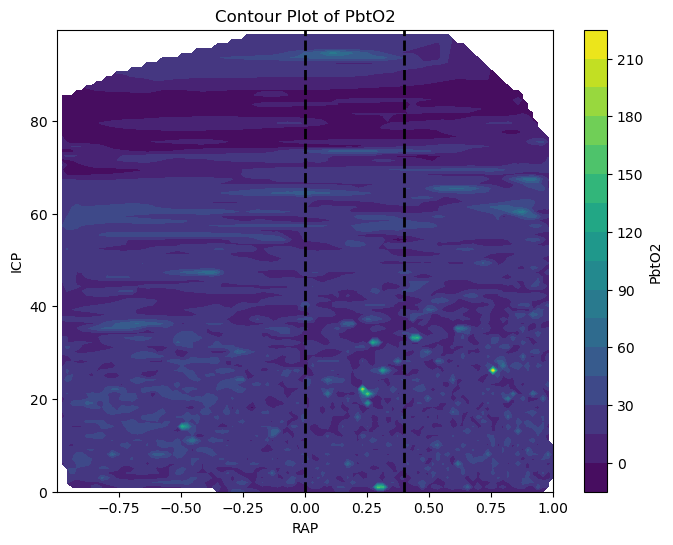

Execution time: 16.98 seconds


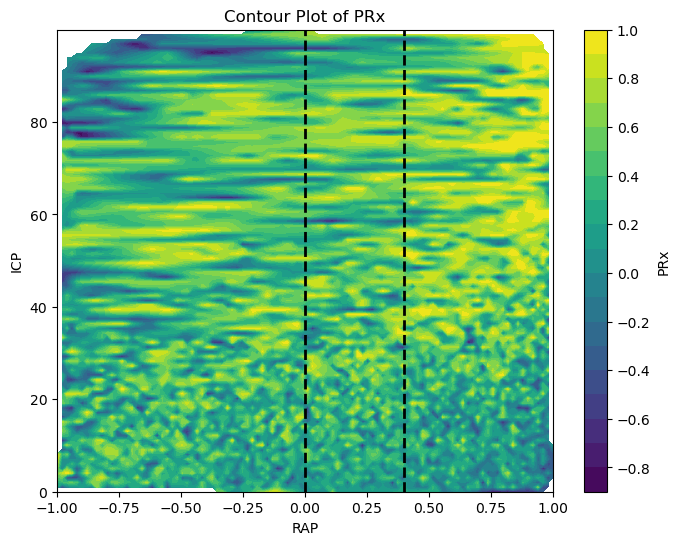

Execution time: 60.41 seconds


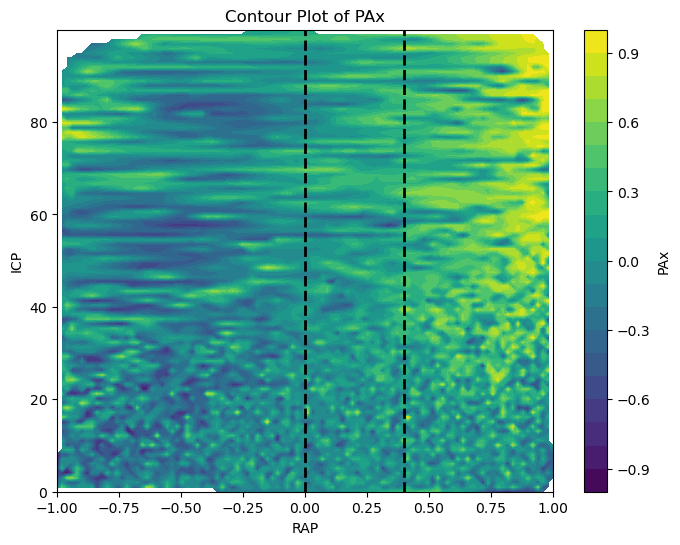

Execution time: 60.38 seconds


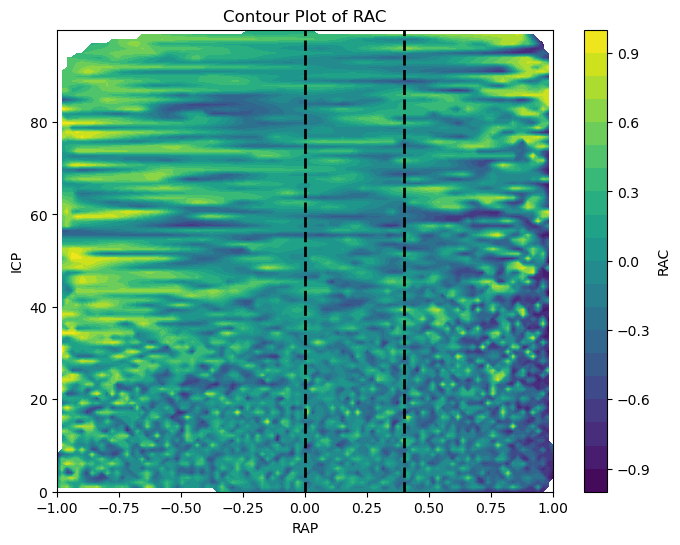

Execution time: 60.91 seconds


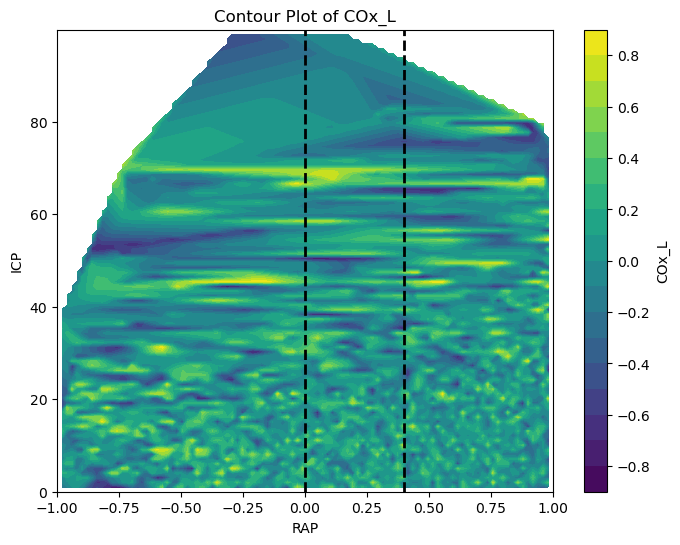

Execution time: 16.7 seconds


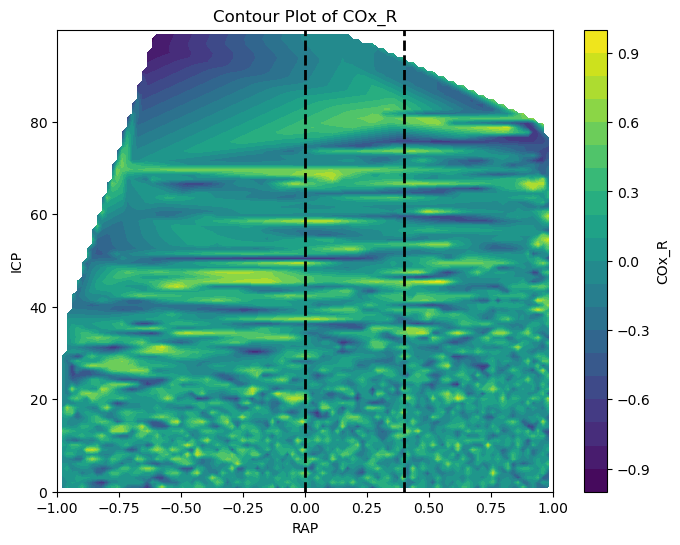

Execution time: 16.68 seconds


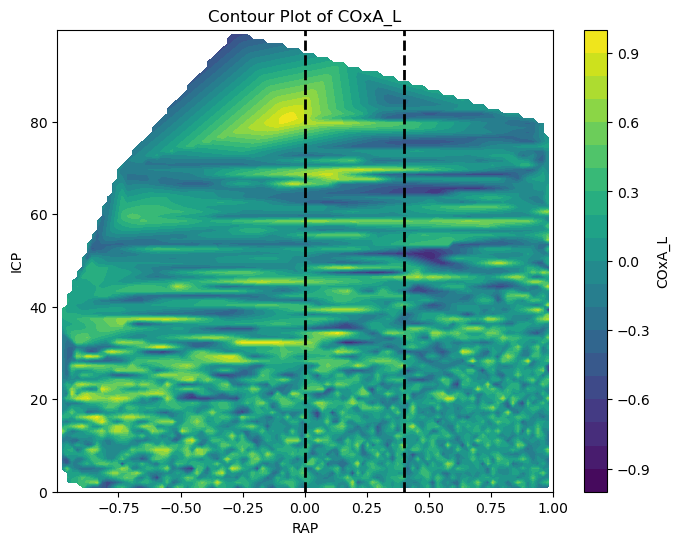

Execution time: 14.09 seconds


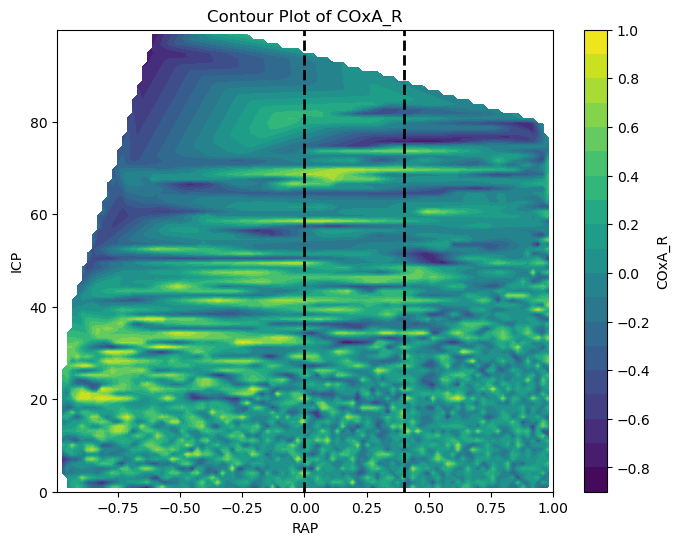

Execution time: 14.56 seconds


In [90]:
# For all the parameters

breakpoints = [0, 0.4]

for index, parameter in enumerate(df_all.columns):
    if index == 0 or index == 1:           # excluding RAP and ICP 
        pass
    else:
        contour_plot_across_full_spectrum(breakpoints, parameter)

# Median Physiology Measures

In [58]:
# Splitting data into three segments

breakpoints = [0, 0.4]

segment1 = df_all[df_all['RAP'] < breakpoints[0]]
segment2 = df_all[(df_all['RAP'] >= breakpoints[0]) & (df_all['RAP'] <= breakpoints[1])]
segment3 = df_all[df_all['RAP'] > breakpoints[1]]

segments = [segment1, segment2, segment3]

labels = ['RAP < 0', '0 ≤ RAP ≤ 0.4', 'RAP > 0.4']

In [61]:
# Median value of each physiology measure
# Defining the dataframe
num_rows = len(labels)
columns = df_all.columns.to_list()
columns.insert(0, 'Labels')

df_median = pd.DataFrame(index=range(num_rows), columns=columns)
NIRS_measures_list = ['RSO2_L', 'RSO2_R', 'COx_L', 'COx_R', 'COxA_L', 'COxA_R']

# Insert median values
for index, segment in enumerate(segments):
    df_median.loc[index] = segment.median().round(3)
    
    for col in segment.columns:
        if col in NIRS_measures_list:
            individual_param = segment[col]
            individual_param = individual_param.loc[individual_param != 0]
            df_median.at[index, parameter] = individual_param.median()
        
df_median['Labels'] = labels
df_median

Labels    RAP    ICP    AMP    MAP    CPP  RSO2_L RSO2_R  PbtO2  \
0        RAP < 0 -0.234  12.03  0.913  90.06  76.69   62.23   64.5   24.0   
1  0 ≤ RAP ≤ 0.4  0.239  12.06  1.081  89.66  76.63  63.635  65.99  21.66   
2      RAP > 0.4  0.873  13.71   1.93  89.46  75.07    65.0  67.79  24.67   

     PRx    PAx    RAC COx_L COx_R COxA_L COxA_R  
0  0.271 -0.147  -0.06   0.0   0.0  0.081  0.047  
1  0.233 -0.016 -0.103   0.0   0.0  0.052  0.032  
2  0.047  -0.03 -0.485   0.0   0.0  0.018  0.002

In [97]:
NIRS_measures_list = ['RSO2_L', 'RSO2_R', 'COx_L', 'COx_R', 'COxA_L', 'COxA_R', 'PbtO2']

for col in segment.columns:
    if col in NIRS_measures_list:
        a_row = segment[col]
        a_row = a_row.loc[a_row != 0]
        print(a_row.median())

Labels    RAP    ICP    AMP    MAP    CPP  RSO2_L RSO2_R  PbtO2  \
0        RAP < 0 -0.234  12.03  0.913  90.06  76.69   62.23   64.5   24.0   
1  0 ≤ RAP ≤ 0.4  0.239  12.06  1.081  89.66  76.63  63.635  65.99  21.66   
2      RAP > 0.4  0.873  13.71   1.93  89.46  75.07    65.0  67.79  24.67   

     PRx    PAx    RAC COx_L COx_R COxA_L  COxA_R  
0  0.271 -0.147  -0.06   0.0   0.0  0.081  0.1081  
1  0.233 -0.016 -0.103   0.0   0.0  0.052  0.0816  
2  0.047  -0.03 -0.485   0.0   0.0  0.018  0.0585

In [99]:
# Median value of each physiology measure
# Defining the dataframe
num_rows = len(labels)
columns = df_all.columns.to_list()
columns.insert(0, 'Labels')

df_median = pd.DataFrame(index=range(num_rows), columns=columns)
NIRS_measures_list = ['RSO2_L', 'RSO2_R', 'COx_L', 'COx_R', 'COxA_L', 'COxA_R', 'PbtO2']

# Insert median values
for index, segment in enumerate(segments):
    df_median.loc[index] = segment.median().round(3)
    
    for col in segment.columns:
        if col in NIRS_measures_list:
            individual_param = segment[col]
            individual_param = individual_param.loc[individual_param != 0]
            df_median.at[index, col] = individual_param.median()
        
df_median['Labels'] = labels
df_median

Labels    RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R  PbtO2  \
0        RAP < 0 -0.234  12.03  0.913  90.06  76.69  68.59  70.62   24.0   
1  0 ≤ RAP ≤ 0.4  0.239  12.06  1.081  89.66  76.63  68.76  71.57  21.71   
2      RAP > 0.4  0.873  13.71   1.93  89.46  75.07  67.67  70.91  24.73   

     PRx    PAx    RAC   COx_L    COx_R   COxA_L  COxA_R  
0  0.271 -0.147  -0.06  0.0692  0.08225   0.1188  0.1081  
1  0.233 -0.016 -0.103  0.0578   0.0634  0.08765  0.0816  
2  0.047  -0.03 -0.485  0.0085   0.0108   0.0657  0.0585

In [80]:
a_row.shape

(2299464, 15)

## Jonckheere-Terpstra testing

In [175]:
save_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Data\Segment_csv\RAP_independent"

for index, segment in enumerate(segments):
    file_name = "segment" + str(index+1) + ".csv"
    segment.to_csv(os.path.join(save_directory, file_name), index=False)

In [95]:
# The rest is conducted in R

# Reverse with Other Physiological Thresholds

## Median

In [96]:
def median_with_other_physiologic_thresholds(segments):
        
    num_rows = len(segments)
    columns = df_all.columns.to_list()
    df_median = pd.DataFrame(index=range(num_rows), columns=columns)

    # Insert median values
    for index, segment in enumerate(segments):
        df_median.loc[index] = segment.median().round(3)
            
    return df_median

## ICP

In [99]:
# Calculating the segments, threshold 20
independent_param = "ICP"
breakpoints = [20]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] >= breakpoints[0]]

segments = [segment1, segment2]

In [100]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0])
df_median

Median based on threshold 20


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R PbtO2    PRx    PAx    RAC  \
0  0.812  12.11  1.589  88.44  76.21  64.75   67.4  24.7  0.059 -0.056   -0.4   
1  0.853  23.64   3.28  95.45  70.27  64.15  66.99  22.0  0.209  0.071 -0.457   

  COx_L COx_R COxA_L COxA_R  
0   0.0   0.0  0.027   0.01  
1   0.0   0.0    0.0    0.0

In [101]:
# Calculating the segments, threshold 22.5
independent_param = "ICP"
breakpoints = [22.5]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] >= breakpoints[0]]

segments = [segment1, segment2]

In [102]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0])
df_median

Median based on threshold 22.5


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R  PbtO2    PRx    PAx  \
0  0.816  12.57  1.649   88.8  75.96   64.8  67.48  24.56  0.063 -0.052   
1  0.844  26.25  3.747  96.64  68.71  63.65  65.81  21.33  0.269  0.114   

     RAC COx_L COx_R COxA_L COxA_R  
0 -0.405   0.0   0.0  0.026  0.009  
1 -0.433   0.0   0.0    0.0    0.0

## CPP

In [110]:
# Calculating the segments, threshold below 60 and above 70
independent_param = "CPP"
breakpoints = [60, 70]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [111]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1])
df_median

Median based on threshold 60 70


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R PbtO2    PRx    PAx    RAC  \
0  0.718  18.41  3.248  72.09  54.46  68.07  71.66  20.0  0.466  0.098  -0.26   
1  0.823  12.64  1.632  94.35  80.69  63.81  66.39  25.0  0.041 -0.053 -0.413   

  COx_L COx_R COxA_L COxA_R  
0   0.0   0.0  0.021    0.0  
1   0.0   0.0  0.029  0.012

## rSO2

In [125]:
independent_param = "RSO2_L"
breakpoints = [60, 70, 80, 90]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] < breakpoints[1]]
segment3 = all_data[all_data[independent_param] < breakpoints[2]]
segment4 = all_data[all_data[independent_param] < breakpoints[3]]

segments = [segment1, segment2, segment3, segment4]

In [127]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1], breakpoints[2], breakpoints[3])
df_median

Median based on threshold 60 70 80 90


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R  PbtO2    PRx    PAx  \
0  0.816  11.11   1.67   90.1  77.76    0.0    0.0   23.0  0.033 -0.034   
1  0.842  11.13  1.791  89.25  76.94  56.93  59.49   22.0  0.026 -0.039   
2  0.842  11.15  1.865  88.65  75.96  63.99  65.86   23.4  0.036 -0.046   
3  0.837  11.23  1.892  88.18  75.48  65.28  66.99  23.28  0.046 -0.043   

     RAC COx_L COx_R COxA_L COxA_R  
0 -0.359   0.0   0.0    0.0  0.008  
1 -0.387   0.0   0.0   0.02  0.012  
2 -0.403   0.0   0.0  0.022  0.008  
3 -0.395   0.0   0.0  0.026  0.009

In [128]:
independent_param = "RSO2_R"
breakpoints = [60, 70, 80, 90]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] < breakpoints[1]]
segment3 = all_data[all_data[independent_param] < breakpoints[2]]
segment4 = all_data[all_data[independent_param] < breakpoints[3]]

segments = [segment1, segment2, segment3, segment4]

In [129]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1], breakpoints[2], breakpoints[3])
df_median

Median based on threshold 60 70 80 90


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R  PbtO2    PRx    PAx  \
0  0.795  10.69  1.543  90.18  78.44    0.0    0.0   23.0  0.051 -0.033   
1  0.834  10.86  1.792  88.99  76.93  54.04  55.03   22.0  0.038 -0.035   
2  0.839  11.14  1.838  88.72  75.79  63.95  65.83  22.01  0.041 -0.038   
3  0.833  11.19   1.86  88.07  75.36  65.28  67.86   23.0  0.047 -0.044   

     RAC COx_L COx_R COxA_L COxA_R  
0 -0.346   0.0   0.0  0.025    0.0  
1 -0.381   0.0   0.0  0.032  0.018  
2 -0.388   0.0   0.0  0.027  0.008  
3 -0.391   0.0   0.0  0.024   0.01

## PbtO2

In [130]:
independent_param = "PbtO2"
breakpoints = [15, 20]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] < breakpoints[1]]

segments = [segment1, segment2]

In [131]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1])
df_median

Median based on threshold 15 20


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R  PbtO2    PRx    PAx  \
0  0.774  15.01  2.486  87.91  73.15  65.89  67.67  8.775  0.187  0.065   
1  0.767  14.66  2.254  88.93  74.13  64.49  65.46  12.99  0.172  0.034   

     RAC COx_L COx_R COxA_L COxA_R  
0  -0.29   0.0   0.0  0.026  0.005  
1 -0.314   0.0   0.0  0.034  0.015

## PRx

In [134]:
independent_param = "PRx"
breakpoints = [0, 0.25, 0.35]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]
segment3 = all_data[all_data[independent_param] > breakpoints[2]]

segments = [segment1, segment2, segment3]

In [135]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1], breakpoints[2])
df_median

Median based on threshold 0 0.25 0.35


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R  PbtO2    PRx    PAx  \
0  0.761  13.87  1.881   89.0  74.32  65.51  67.99  23.06   0.35  0.169   
1  0.721  14.39   2.03  88.47  73.22  65.99  67.99   22.0  0.528  0.296   
2  0.701  14.73  2.132   88.1  72.55  65.99  67.99  21.46  0.606  0.347   

     RAC COx_L COx_R COxA_L COxA_R  
0  -0.21   0.0   0.0  0.052  0.024  
1 -0.095   0.0   0.0  0.059  0.024  
2 -0.043   0.0   0.0  0.062  0.024

## PAx

In [140]:
independent_param = "PAx"
breakpoints = [0, 0.25]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [141]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1])
df_median

Median based on threshold 0 0.25


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R PbtO2    PRx    PAx    RAC  \
0  0.798  14.07  1.963  89.63  74.79  64.81  67.31  23.0  0.339  0.275 -0.031   
1  0.804  14.61  2.184  89.41   74.0  64.65  66.99  22.0  0.505  0.457  0.177   

  COx_L COx_R COxA_L COxA_R  
0   0.0   0.0  0.048  0.017  
1   0.0   0.0  0.056  0.016

## RAC

In [142]:
independent_param = "RAC"
breakpoints = [0]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] < breakpoints[0]]

segments = [segment1, segment2]

In [143]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0])
df_median

Median based on threshold 0


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R PbtO2    PRx    PAx    RAC  \
0  0.608  13.06  1.535  88.82  74.97   63.9  66.65  21.0  0.455  0.402  0.247   
1  0.865  13.58  1.833  89.66  75.36  65.08  67.99  25.0 -0.008 -0.152 -0.546   

  COx_L COx_R COxA_L COxA_R  
0   0.0   0.0  0.046  0.004  
1   0.0   0.0  0.018  0.008

## COx

In [145]:
independent_param = "COx_L"
breakpoints = [0, 0.20]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [146]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1])
df_median

Median based on threshold 0 0.2


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R PbtO2    PRx    PAx    RAC  \
0  0.822  10.95  1.864  85.98  74.35  68.16  70.73  24.0  0.092 -0.022 -0.353   
1  0.807  10.92  1.851  86.43  74.78  67.99   70.4  23.0  0.098 -0.035 -0.345   

   COx_L  COx_R COxA_L COxA_R  
0  0.231  0.131  0.263  0.143  
1  0.386  0.249  0.394  0.233

In [147]:
independent_param = "COx_R"
breakpoints = [0, 0.20]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [148]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1])
df_median

Median based on threshold 0 0.2


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R  PbtO2    PRx    PAx  \
0  0.821  10.95   1.85  85.76  74.11   68.0  71.17  23.27  0.083 -0.035   
1  0.807   10.9  1.832  86.14  74.52   67.9  70.91   23.0  0.089  -0.05   

     RAC  COx_L  COx_R COxA_L COxA_R  
0 -0.362  0.133  0.228  0.158  0.251  
1 -0.358  0.254  0.384  0.254  0.386

## COx-a

In [149]:
independent_param = "COxA_L"
breakpoints = [0, 0.20]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [150]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1])
df_median

Median based on threshold 0 0.2


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R  PbtO2    PRx    PAx  \
0  0.849  10.86  1.925  85.61  73.91  66.92  68.75  16.26  0.078 -0.015   
1  0.837  10.86  1.928  86.04  74.27  66.72  68.68  16.84   0.09  -0.02   

     RAC  COx_L  COx_R COxA_L COxA_R  
0 -0.376  0.193  0.074  0.248  0.142  
1 -0.369  0.338  0.168  0.387  0.245

In [151]:
independent_param = "COxA_R"
breakpoints = [0, 0.20]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [152]:
df_median = median_with_other_physiologic_thresholds(segments)
print("Median based on threshold", breakpoints[0], breakpoints[1])
df_median

Median based on threshold 0 0.2


RAP    ICP    AMP    MAP    CPP RSO2_L RSO2_R  PbtO2    PRx    PAx  \
0  0.846  10.75  1.888  85.29  73.73  66.75   69.4  15.78  0.067 -0.028   
1  0.836  10.68  1.865  85.53  73.96  66.52  69.04   16.8  0.078 -0.038   

     RAC  COx_L  COx_R COxA_L COxA_R  
0 -0.383  0.085  0.192  0.157  0.238  
1  -0.38  0.184  0.338  0.266  0.382

## Jonckheere-Terpstra testing

## rSO2

In [178]:
independent_param = "RSO2_L"
breakpoints = [60, 70, 80, 90]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] < breakpoints[1]]
segment3 = all_data[all_data[independent_param] < breakpoints[2]]
segment4 = all_data[all_data[independent_param] < breakpoints[3]]

segments = [segment1, segment2, segment3, segment4]

save_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Segment_csv\Other_variables_independent"

for index, segment in enumerate(segments):
    file_name = independent_param + "_segment" + str(index+1) + ".csv"
    segment.to_csv(os.path.join(save_directory, file_name), index=False)

In [112]:
# The Rest is done in R

In [180]:
independent_param = "RSO2_R"
breakpoints = [60, 70, 80, 90]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] < breakpoints[1]]
segment3 = all_data[all_data[independent_param] < breakpoints[2]]
segment4 = all_data[all_data[independent_param] < breakpoints[3]]

segments = [segment1, segment2, segment3, segment4]

save_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Segment_csv\Other_variables_independent"

for index, segment in enumerate(segments):
    file_name = independent_param + "_segment" + str(index+1) + ".csv"
    segment.to_csv(os.path.join(save_directory, file_name), index=False)

In [181]:
# The Rest is done in R

## PRx

In [182]:
independent_param = "PRx"
breakpoints = [0, 0.25, 0.35]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]
segment3 = all_data[all_data[independent_param] > breakpoints[2]]

segments = [segment1, segment2, segment3]

save_directory = r"D:\Thesis Project\Thesis Project 2\Research Phase 4\Segment_csv\Other_variables_independent"

for index, segment in enumerate(segments):
    file_name = independent_param + "_segment" + str(index+1) + ".csv"
    segment.to_csv(os.path.join(save_directory, file_name), index=False)

In [183]:
# The Rest is done in R

## Mann_Whitney_U_Test

In [124]:
def mann_whitney_U_test_result(segments):
    
    df_comparison = pd.DataFrame(index=range(2), columns=segments[0].columns)

    for parameter in segments[0].columns:
        stat, p_value = mannwhitneyu(segments[0][parameter].dropna(), segments[1][parameter].dropna())
        df_comparison.at[0, parameter] = stat
        df_comparison.at[1, parameter] = p_value
        
    df_comparison = df_comparison.applymap(lambda x: "{:.2e}".format(x))
    
    return df_comparison

## ICP

In [114]:
# Calculating the segments, threshold 20
independent_param = "ICP"
breakpoints = [20]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] >= breakpoints[0]]

segments = [segment1, segment2]

In [123]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP       AMP       MAP       CPP    RSO2_L    RSO2_R  \
0  6.24e+11  0.00e+00  3.31e+11  4.53e+11  8.29e+11  3.84e+10  3.85e+10   
1  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  5.33e-01  4.48e-01   

      PbtO2       PRx       PAx       RAC     COx_L     COx_R    COxA_L  \
0  1.41e+11  5.29e+11  5.36e+11  6.70e+11  3.56e+10  3.53e+10  1.69e+10   
1  0.00e+00  0.00e+00  0.00e+00  0.00e+00  6.88e-22  5.66e-10  2.19e-07   

     COxA_R  
0  1.70e+10  
1  2.52e-15

In [153]:
# Calculating the segments, threshold 22.5
independent_param = "ICP"
breakpoints = [22.5]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] >= breakpoints[0]]

segments = [segment1, segment2]

In [154]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP       AMP       MAP       CPP    RSO2_L    RSO2_R  \
0  4.30e+11  0.00e+00  2.01e+11  2.94e+11  5.77e+11  2.42e+10  2.52e+10   
1  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  3.19e-26  1.25e-74   

      PbtO2       PRx       PAx       RAC     COx_L     COx_R    COxA_L  \
0  1.03e+11  3.34e+11  3.41e+11  4.36e+11  2.16e+10  2.18e+10  1.02e+10   
1  0.00e+00  0.00e+00  0.00e+00  9.14e-38  1.31e-07  7.86e-02  3.19e-03   

     COxA_R  
0  1.05e+10  
1  5.27e-04

## CPP

In [155]:
# Calculating the segments, threshold below 60 and above 70
independent_param = "CPP"
breakpoints = [60, 70]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [156]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP       AMP       MAP       CPP    RSO2_L    RSO2_R  \
0  2.41e+11  4.20e+11  4.16e+11  3.37e+10  0.00e+00  2.42e+10  2.37e+10   
1  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00   

      PbtO2       PRx       PAx       RAC     COx_L      COx_R    COxA_L  \
0  5.33e+10  3.90e+11  3.25e+11  3.14e+11  1.99e+10   2.00e+10  8.89e+09   
1  0.00e+00  0.00e+00  0.00e+00  0.00e+00  3.46e-69  6.22e-101  8.40e-23   

     COxA_R  
0  8.80e+09  
1  7.59e-08

## PbtO2

In [157]:
independent_param = "PbtO2"
breakpoints = [15, 20]
all_data = df_all

segment1 = all_data[all_data[independent_param] < breakpoints[0]]
segment2 = all_data[all_data[independent_param] < breakpoints[1]]

segments = [segment1, segment2]

In [158]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP        AMP       MAP        CPP     RSO2_L    RSO2_R  \
0  5.69e+10  5.80e+10   5.93e+10  6.20e+10   5.04e+10   5.99e+09  7.33e+09   
1  2.39e-34  4.53e-86  3.32e-310  3.44e-76  1.62e-191  5.07e-263  0.00e+00   

      PbtO2       PRx        PAx       RAC     COx_L     COx_R    COxA_L  \
0  4.31e+10  5.29e+10   5.40e+10  5.36e+10  4.35e+09  5.08e+09  2.21e+09   
1  0.00e+00  1.06e-26  1.06e-159  1.56e-95  8.85e-18  2.39e-19  6.14e-06   

     COxA_R  
0  2.87e+09  
1  1.79e-11

## PAx

In [159]:
independent_param = "PAx"
breakpoints = [0, 0.25]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [160]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP       AMP       MAP       CPP    RSO2_L    RSO2_R  \
0   5.19e+11  5.05e+11  4.91e+11  5.32e+11  5.42e+11  4.54e+10  4.68e+10   
1  3.93e-179  0.00e+00  0.00e+00  1.53e-30  0.00e+00  6.80e-05  1.95e-24   

      PbtO2       PRx       PAx       RAC     COx_L     COx_R    COxA_L  \
0  9.33e+10  4.04e+11  2.87e+11  4.13e+11  4.42e+10  4.54e+10  2.10e+10   
1  7.15e-74  0.00e+00  0.00e+00  0.00e+00  1.60e-45  3.57e-22  6.93e-23   

     COxA_R  
0  2.20e+10  
1  7.76e-04

## RAC

In [163]:
independent_param = "RAC"
breakpoints = [0]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] < breakpoints[0]]

segments = [segment1, segment2]

In [164]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP       AMP       MAP        CPP     RSO2_L    RSO2_R  \
0  4.51e+11  7.53e+11  7.24e+11  7.51e+11   7.60e+11   6.74e+10  6.80e+10   
1  0.00e+00  0.00e+00  0.00e+00  0.00e+00  7.01e-202  4.63e-240  0.00e+00   

      PbtO2       PRx       PAx       RAC     COx_L     COx_R     COxA_L  \
0  1.09e+11  1.21e+12  1.44e+12  1.58e+12  7.76e+10  7.77e+10   3.44e+10   
1  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.13e-203   

     COxA_R  
0  3.46e+10  
1  1.08e-27

## COx

In [165]:
independent_param = "COx_L"
breakpoints = [0, 0.20]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [166]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP       AMP       MAP       CPP    RSO2_L    RSO2_R  \
0  3.28e+10  3.16e+10  3.17e+10  3.37e+10  3.10e+10  3.51e+10  2.97e+10   
1  3.89e-73  1.97e-01  3.71e-01  5.90e-32  1.80e-15  6.36e-26  4.33e-09   

      PbtO2       PRx       PAx       RAC     COx_L     COx_R    COxA_L  \
0  2.97e+09  3.18e+10  3.24e+10  3.16e+10  1.93e+10  2.42e+10  1.55e+10   
1  9.45e-34  1.57e-01  3.24e-25  7.83e-07  0.00e+00  0.00e+00  0.00e+00   

     COxA_R  
0  1.61e+10  
1  0.00e+00

In [167]:
independent_param = "COx_R"
breakpoints = [0, 0.20]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [168]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP       AMP       MAP       CPP    RSO2_L    RSO2_R  \
0  3.24e+10  3.14e+10  3.16e+10  3.33e+10  3.07e+10  2.90e+10  3.46e+10   
1  1.18e-54  7.30e-01  7.05e-05  7.47e-26  5.49e-17  1.57e-14  2.05e-19   

      PbtO2       PRx       PAx       RAC     COx_L     COx_R    COxA_L  \
0  3.34e+09  3.15e+10  3.22e+10  3.15e+10  2.35e+10  1.88e+10  1.52e+10   
1  1.08e-11  3.40e-01  1.44e-36  9.00e-02  0.00e+00  0.00e+00  0.00e+00   

     COxA_R  
0  1.49e+10  
1  0.00e+00

## COx-a

In [169]:
independent_param = "COxA_L"
breakpoints = [0, 0.20]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [170]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP       AMP       MAP       CPP    RSO2_L    RSO2_R  \
0  3.09e+10  3.01e+10  3.01e+10  3.29e+10  2.95e+10  3.39e+10  2.74e+10   
1  1.72e-44  8.04e-02  7.17e-02  9.23e-28  7.35e-16  1.40e-05  4.32e-01   

      PbtO2       PRx       PAx       RAC     COx_L     COx_R    COxA_L  \
0  1.30e+09  2.98e+10  3.04e+10  2.99e+10  2.13e+10  2.14e+10  1.98e+10   
1  9.75e-09  3.41e-13  6.24e-08  1.07e-08  0.00e+00  0.00e+00  0.00e+00   

     COxA_R  
0  2.32e+10  
1  0.00e+00

In [171]:
independent_param = "COxA_R"
breakpoints = [0, 0.20]
all_data = df_all

segment1 = all_data[all_data[independent_param] > breakpoints[0]]
segment2 = all_data[all_data[independent_param] > breakpoints[1]]

segments = [segment1, segment2]

In [172]:
df_comparison = mann_whitney_U_test_result(segments)
df_comparison

RAP       ICP       AMP       MAP       CPP    RSO2_L    RSO2_R  \
0  2.88e+10  2.83e+10  2.83e+10  3.07e+10  2.77e+10  2.53e+10  3.16e+10   
1  5.03e-37  3.07e-02  5.00e-04  4.31e-10  7.24e-09  7.71e-03  4.29e-12   

      PbtO2       PRx       PAx       RAC     COx_L     COx_R    COxA_L  \
0  1.37e+09  2.79e+10  2.86e+10  2.80e+10  1.95e+10  1.96e+10  2.10e+10   
1  7.58e-36  6.08e-08  4.83e-22  1.88e-03  0.00e+00  0.00e+00  0.00e+00   

     COxA_R  
0  1.79e+10  
1  0.00e+00